# Chapter 1c: Temporal Pattern Analysis (Event Bronze Track)

**Purpose:** Discover temporal patterns in event-level data that inform feature engineering and model design.

**When to use this notebook:**
- After completing 01a and 01b (temporal deep dive and quality checks)
- Your dataset is EVENT_LEVEL granularity
- You want to understand time-based patterns before aggregation

**What you'll learn:**
- How to detect long-term trends in your data
- How to identify seasonality patterns (weekly, monthly)
- How cohort analysis reveals customer lifecycle patterns
- How recency relates to target outcomes

**Pattern Categories:**

| Pattern | Description | Feature Engineering Impact |
|---------|-------------|---------------------------|
| **Trend** | Long-term direction (up/down) | Detrend features, add trend slope |
| **Seasonality** | Periodic patterns (weekly, monthly) | Add cyclical encodings, seasonal indicators |
| **Cohort Effects** | Behavior varies by join date | Add cohort features, stratify models |
| **Recency Effects** | Recent activity predicts outcomes | Prioritize recent time windows |

## 1c.1 Load Findings and Data

In [1]:
from customer_retention.analysis.auto_explorer import ExplorationFindings
from customer_retention.analysis.visualization import ChartBuilder, display_figure, display_table
from customer_retention.core.config.column_config import ColumnType, DatasetGranularity
from customer_retention.stages.profiling import (
    TemporalPatternAnalyzer, TemporalPatternAnalysis,
    TrendResult, TrendDirection, SeasonalityResult, RecencyResult,
    TemporalFeatureAnalyzer, VelocityResult, MomentumResult,
    LagCorrelationResult, PredictivePowerResult, FeatureRecommendation,
    CategoricalTargetAnalyzer
)
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
from customer_retention.core.config.experiments import FINDINGS_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, setup_experiments_structure


In [2]:
# === CONFIGURATION ===
from pathlib import Path

# FINDINGS_DIR imported from customer_retention.core.config.experiments

findings_files = [f for f in FINDINGS_DIR.glob("*_findings.yaml") if "multi_dataset" not in f.name]
if not findings_files:
    raise FileNotFoundError(f"No findings files found in {FINDINGS_DIR}. Run notebook 01 first.")

findings_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
FINDINGS_PATH = str(findings_files[0])

print(f"Using: {FINDINGS_PATH}")
findings = ExplorationFindings.load(FINDINGS_PATH)
print(f"Loaded findings for {findings.column_count} columns")

Using: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_findings.yaml
Loaded findings for 16 columns


In [3]:
# Get time series configuration
ts_meta = findings.time_series_metadata
ENTITY_COLUMN = ts_meta.entity_column if ts_meta else None
TIME_COLUMN = ts_meta.time_column if ts_meta else None

print(f"Entity column: {ENTITY_COLUMN}")
print(f"Time column: {TIME_COLUMN}")

# Note: Target column configuration is handled in section 1c.2 below
# This allows for event-level to entity-level aggregation when needed

Entity column: customer_id
Time column: feature_timestamp


In [4]:
from customer_retention.stages.temporal import load_data_with_snapshot_preference, TEMPORAL_METADATA_COLS

# Load source data (prefers snapshots over raw files)
df, data_source = load_data_with_snapshot_preference(findings, output_dir=str(FINDINGS_DIR))
charts = ChartBuilder()

# Parse time column
df[TIME_COLUMN] = pd.to_datetime(df[TIME_COLUMN])

print(f"Loaded {len(df):,} rows x {len(df.columns)} columns")
print(f"Data source: {data_source}")

Loaded 74,842 rows x 16 columns
Data source: snapshot


## 1c.2 Target Column Configuration

**📖 Event-Level vs Entity-Level Targets:**

In time series data, targets can be defined at different granularities:

| Target Level | Example | Usage |
|--------------|---------|-------|
| **Event-level** | "Did this email get clicked?" | Exists in raw data |
| **Entity-level** | "Did this customer churn?" | Need to join from entity table |

If your target is entity-level, you may need to join it or configure it manually.

In [5]:
# === TARGET CONFIGURATION ===
# Override target column if needed (None = auto-detect, "DEFER_TO_MULTI_DATASET" = skip)
TARGET_COLUMN_OVERRIDE = None
TARGET_AGGREGATION = "max"  # Options: "max", "mean", "sum", "last", "first"

# Detect and analyze target
from customer_retention.stages.profiling import (
    TargetLevelAnalyzer, TargetColumnDetector, AggregationMethod
)

detector = TargetColumnDetector()
target_col, method = detector.detect(findings, df, override=TARGET_COLUMN_OVERRIDE)
detector.print_detection(target_col, method)

TARGET_COLUMN = target_col
if TARGET_COLUMN and TARGET_COLUMN in df.columns and ENTITY_COLUMN:
    analyzer = TargetLevelAnalyzer()
    agg_method = AggregationMethod(TARGET_AGGREGATION)
    df, result = analyzer.aggregate_to_entity(df, TARGET_COLUMN, ENTITY_COLUMN, TIME_COLUMN, agg_method)
    analyzer.print_analysis(result)
    
    # Update TARGET_COLUMN to entity-level version if aggregated
    if result.entity_target_column:
        ORIGINAL_TARGET = TARGET_COLUMN
        TARGET_COLUMN = result.entity_target_column

print("\n" + "─"*70)
print(f"Final configuration:")
print(f"   ENTITY_COLUMN: {ENTITY_COLUMN}")
print(f"   TIME_COLUMN: {TIME_COLUMN}")
print(f"   TARGET_COLUMN: {TARGET_COLUMN}")
print("─"*70)



🔍 Auto-detected target: target
TARGET LEVEL ANALYSIS

Column: target
Level: EVENT_LEVEL

⚠️  EVENT-LEVEL TARGET DETECTED
   38.8% of entities have varying target values

   Event-level distribution:
      target=0: 72,869 events (97.4%)
      target=1: 1,973 events (2.6%)

   Suggested aggregation: max

   Aggregation applied: max
   Entity target column: target_entity

   Entity-level distribution (after aggregation):
      Retained (target_entity=0): 3,025 entities (60.5%)
      Churned (target_entity=1): 1,973 entities (39.5%)


──────────────────────────────────────────────────────────────────────
Final configuration:
   ENTITY_COLUMN: customer_id
   TIME_COLUMN: feature_timestamp
   TARGET_COLUMN: target_entity
──────────────────────────────────────────────────────────────────────


## 1c.3 Aggregation Window Configuration

**⚙️ Central Configuration for All Pattern Analysis**

Windows are loaded from 01a findings and used consistently throughout this notebook for:
- Velocity analysis (shortest window)
- Momentum analysis (window pairs)
- Rolling statistics
- Feature engineering recommendations

Override below if needed for your specific analysis.


In [6]:
# === AGGREGATION WINDOW CONFIGURATION ===
# These windows were recommended by 01a based on your data's temporal coverage.
# They are used consistently for velocity, momentum, rolling stats, and feature engineering.

# Override: Set to a list like ["7d", "30d", "90d"] to use custom windows
# Set to None to use 01a recommendations
WINDOW_OVERRIDE = None

from customer_retention.stages.profiling import PatternAnalysisConfig

pattern_config = PatternAnalysisConfig.from_findings(
    findings,
    target_column=TARGET_COLUMN,
    window_override=WINDOW_OVERRIDE,
)

# Display configuration
print("="*70)
print("AGGREGATION WINDOW CONFIGURATION")
print("="*70)
print(f"\nSource: {'Manual override' if WINDOW_OVERRIDE else '01a findings (recommended)'}")
print(f"\nWindows: {pattern_config.aggregation_windows}")
print(f"\nDerived settings used throughout this notebook:")
print(f"   • Velocity/Rolling window: {pattern_config.velocity_window_days} days")
print(f"   • Momentum pairs: {pattern_config.get_momentum_pairs()}")
print(f"\n💡 To override, set WINDOW_OVERRIDE = ['7d', '30d', '90d'] above and re-run")


AGGREGATION WINDOW CONFIGURATION

Source: 01a findings (recommended)

Windows: ['180d', '365d', 'all_time']

Derived settings used throughout this notebook:
   • Velocity/Rolling window: 180 days
   • Momentum pairs: [(180, 365)]

💡 To override, set WINDOW_OVERRIDE = ['7d', '30d', '90d'] above and re-run


## 1c.4 Configure Value Column for Analysis

Temporal patterns are analyzed on aggregated metrics. Choose the primary metric to analyze.

In [7]:
# Find numeric columns for pattern analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [ENTITY_COLUMN] and c not in TEMPORAL_METADATA_COLS]

# Separate target columns from feature columns
target_cols = [c for c in numeric_cols if c.lower() in ['target', 'target_entity', 'label'] 
               or (TARGET_COLUMN and c.lower() == TARGET_COLUMN.lower())]
feature_cols = [c for c in numeric_cols if c not in target_cols]

print("Numeric columns for pattern analysis:")
print("\n  FEATURE COLUMNS (can derive features from):")
for col in feature_cols:
    print(f"    - {col}")

if target_cols:
    print("\n  TARGET COLUMNS (analysis only - never derive features):")
    for col in target_cols:
        print(f"    - {col} [TARGET]")

# Default: use event count (most common for pattern detection)
# Change this to analyze patterns in a specific metric
VALUE_COLUMN = "_event_count"  # Special: will aggregate event counts

Numeric columns for pattern analysis:

  FEATURE COLUMNS (can derive features from):
    - opened
    - clicked
    - send_hour
    - bounced
    - time_to_open_hours

  TARGET COLUMNS (analysis only - never derive features):
    - target [TARGET]
    - target_entity [TARGET]


In [8]:
# Prepare data for pattern analysis
# Aggregate to daily level for trend/seasonality detection

if VALUE_COLUMN == "_event_count":
    # Aggregate event counts by day
    daily_data = df.groupby(df[TIME_COLUMN].dt.date).size().reset_index()
    daily_data.columns = [TIME_COLUMN, "value"]
    daily_data[TIME_COLUMN] = pd.to_datetime(daily_data[TIME_COLUMN])
    analysis_col = "value"
    print("Analyzing: Daily event counts")
else:
    # Aggregate specific column by day
    daily_data = df.groupby(df[TIME_COLUMN].dt.date)[VALUE_COLUMN].sum().reset_index()
    daily_data.columns = [TIME_COLUMN, "value"]
    daily_data[TIME_COLUMN] = pd.to_datetime(daily_data[TIME_COLUMN])
    analysis_col = "value"
    print(f"Analyzing: Daily sum of {VALUE_COLUMN}")

print(f"\nDaily data points: {len(daily_data)}")
print(f"Date range: {daily_data[TIME_COLUMN].min()} to {daily_data[TIME_COLUMN].max()}")

Analyzing: Daily event counts

Daily data points: 2826
Date range: 2015-01-01 00:00:00 to 2022-09-26 00:00:00


## 1c.5 Trend Detection

**📖 Understanding Trends:**
- **Increasing**: Metric growing over time (e.g., expanding customer base)
- **Decreasing**: Metric shrinking (e.g., declining engagement)
- **Stationary**: No significant trend (stable business)

**Impact on ML:**
- Strong trends can cause data leakage if not handled
- Consider detrending or adding trend as explicit feature

Trend: ➡️ STABLE (R²=0.47)


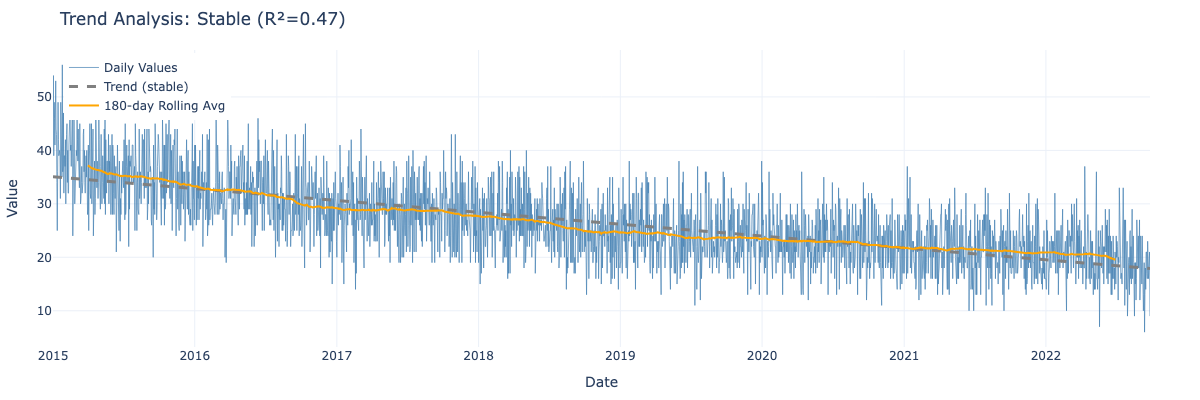

In [9]:
# Trend Analysis - computation and visualization
from customer_retention.stages.profiling import generate_trend_recommendations

analyzer = TemporalPatternAnalyzer(time_column=TIME_COLUMN)
trend_result = analyzer.detect_trend(daily_data, value_column=analysis_col)
trend_recs = generate_trend_recommendations(trend_result, mean_value=daily_data[analysis_col].mean())

# Visualization
direction_emoji = {"increasing": "📈", "decreasing": "📉", "stable": "➡️", "unknown": "❓"}
print(f"Trend: {direction_emoji.get(trend_result.direction.value, '')} {trend_result.direction.value.upper()} (R²={trend_result.strength:.2f})")

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=daily_data[TIME_COLUMN], y=daily_data[analysis_col],
    mode="lines", name="Daily Values", line=dict(color="steelblue", width=1), opacity=0.7
))

if trend_result.slope is not None:
    x_numeric = (daily_data[TIME_COLUMN] - daily_data[TIME_COLUMN].min()).dt.days
    y_trend = trend_result.slope * x_numeric + (daily_data[analysis_col].mean() - trend_result.slope * x_numeric.mean())
    trend_color = {TrendDirection.INCREASING: "green", TrendDirection.DECREASING: "red"}.get(trend_result.direction, "gray")
    fig.add_trace(go.Scatter(
        x=daily_data[TIME_COLUMN], y=y_trend, mode="lines",
        name=f"Trend ({trend_result.direction.value})", line=dict(color=trend_color, width=3, dash="dash")
    ))

rolling_avg = daily_data[analysis_col].rolling(window=pattern_config.rolling_window, center=True).mean()
fig.add_trace(go.Scatter(
    x=daily_data[TIME_COLUMN], y=rolling_avg, mode="lines",
    name=f"{pattern_config.rolling_window}-day Rolling Avg", line=dict(color="orange", width=2)
))

fig.update_layout(
    title=f"Trend Analysis: {trend_result.direction.value.title()} (R²={trend_result.strength:.2f})",
    xaxis_title="Date", yaxis_title="Value", template="plotly_white", height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
display_figure(fig)

In [10]:
# Trend details and recommendations
print("📈 TREND ANALYSIS DETAILS")
print("="*50)
print(f"\n   Direction: {trend_result.direction.value.upper()}")
print(f"   Strength (R²): {trend_result.strength:.3f}")
print(f"   Confidence: {trend_result.confidence.upper()}")

if trend_result.slope is not None:
    mean_val = daily_data[analysis_col].mean()
    daily_pct = (trend_result.slope / mean_val * 100) if mean_val else 0
    print(f"   Slope: {trend_result.slope:.4f} per day ({daily_pct:+.3f}%/day)")
if trend_result.p_value is not None:
    print(f"   P-value: {trend_result.p_value:.4f}")

print("\n📋 RECOMMENDATIONS:")
for rec in trend_recs:
    priority_icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(rec.priority, "⚪")
    print(f"   {priority_icon} [{rec.priority.upper()}] {rec.action}")
    print(f"      {rec.reason}")
    if rec.features:
        print(f"      Features: {', '.join(rec.features)}")

TREND_RECOMMENDATIONS = [{"action": r.action, "priority": r.priority, "reason": r.reason, 
                          "features": r.features} for r in trend_recs]

📈 TREND ANALYSIS DETAILS

   Direction: STABLE
   Strength (R²): 0.465
   Confidence: MEDIUM
   Slope: -0.0061 per day (-0.023%/day)
   P-value: 0.0000

📋 RECOMMENDATIONS:
   🟢 [LOW] skip_trend_features
      No significant trend (R²=0.47) - trend features unlikely to help


## 1c.6 Seasonality Detection

**📖 Understanding Seasonality:**
- **Weekly** (period=7): Higher activity on certain days
- **Monthly** (period~30): End-of-month patterns, billing cycles
- **Quarterly** (period~90): Business cycles, seasonal products

**📊 Interpreting Strength (Autocorrelation):**

Strength measures how well values at a given lag correlate with current values.

| Strength | Interpretation | Random Data Baseline |
|----------|----------------|---------------------|
| 0.0 | No pattern (random noise) | ≈ 0.0 |
| 0.1–0.3 | Weak pattern | Barely above random |
| 0.3–0.5 | Moderate pattern | 3–5× lift over random |
| 0.5–0.7 | Strong pattern | Clear repeating cycle |
| > 0.7 | Very strong pattern | Near-deterministic cycle |

*Lift interpretation: A strength of 0.4 means the pattern explains ~40% of variance at that lag, vs ~0% for random data.*

**🎯 Window-Aligned Pattern Detection:**

We check two types of patterns:
- **Natural periods** (7, 14, 21, 30 days): Calendar-driven cycles
- **Aggregation windows** (from findings): Patterns at your selected feature windows (e.g., 180d, 365d)

If a pattern aligns with your aggregation window, features computed over that window may capture the full cycle — consider this when interpreting aggregated features.

**Impact on ML:**
- Add day-of-week, month features for detected periods
- Consider seasonal decomposition for strong patterns
- Use cyclical encodings (sin/cos) for neural networks

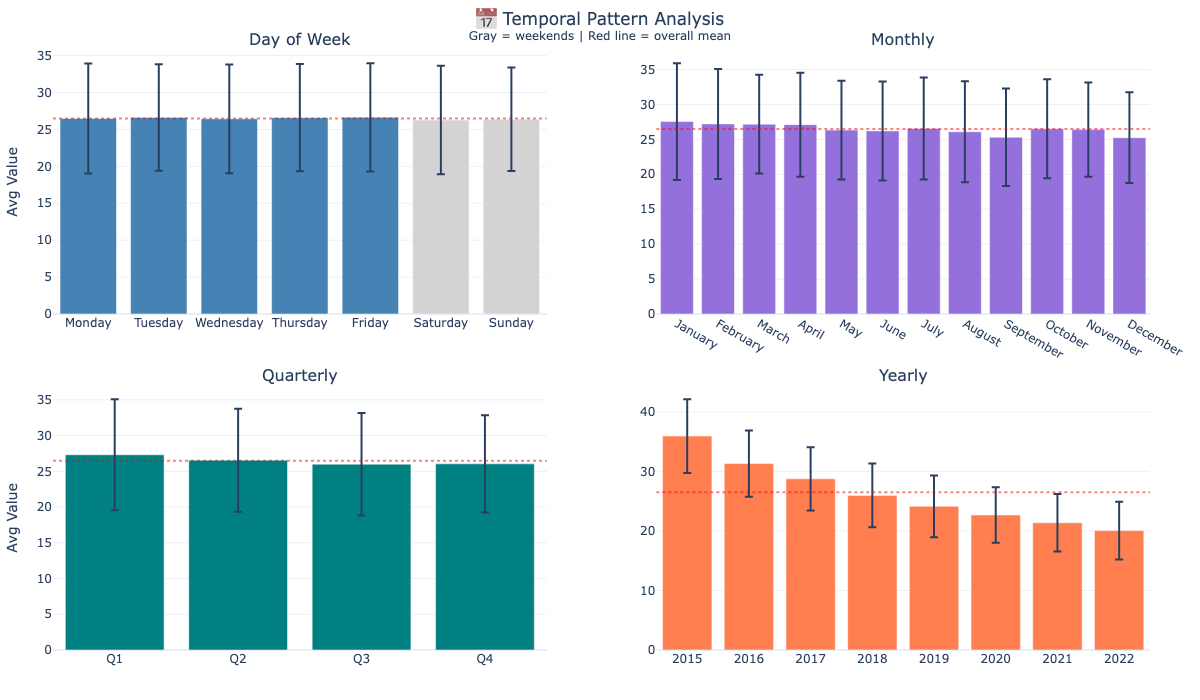

📊 SEASONALITY & TEMPORAL PATTERN ANALYSIS

📈 Pattern Variation (% from mean):
   Day of Week: 1.4%
   Monthly:     8.7%
   Quarterly:   5.0%
   Yearly:      59.9%

🔁 Autocorrelation Seasonality (threshold > 0.3):
   • weekly: 0.484 (Moderate)
   • tri-weekly: 0.479 (Moderate)
   • bi-weekly: 0.474 (Moderate)

────────────────────────────────────────────────────────────
📋 SEASONALITY RECOMMENDATIONS:
────────────────────────────────────────────────────────────

🔴 [HIGH] Year
   59.9% variation but NO linear trend - use categorical
   ⚠️  Stepwise changes or non-linear cycles suspected
   → Features: year_categorical

🟡 [MEDIUM] 7D Cycle
   Autocorrelation 0.48 at 7d - add lag ratio feature
   → Features: lag_7d_ratio

🟡 [MEDIUM] 21D Cycle
   Autocorrelation 0.48 at 21d - add lag ratio feature
   → Features: lag_21d_ratio

🟡 [MEDIUM] 14D Cycle
   Autocorrelation 0.47 at 14d - add lag ratio feature
   → Features: lag_14d_ratio


In [11]:
# Seasonality Analysis - Temporal Pattern Grid + Autocorrelation
from plotly.subplots import make_subplots

# Prepare temporal columns
daily_data["day_of_week"] = daily_data[TIME_COLUMN].dt.day_name()
daily_data["month"] = daily_data[TIME_COLUMN].dt.month_name()
daily_data["quarter"] = "Q" + daily_data[TIME_COLUMN].dt.quarter.astype(str)
daily_data["year"] = daily_data[TIME_COLUMN].dt.year.astype(str)

dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
daily_data["day_of_week"] = pd.Categorical(daily_data["day_of_week"], categories=[d for d in dow_order if d in daily_data["day_of_week"].values], ordered=True)
daily_data["month"] = pd.Categorical(daily_data["month"], categories=[m for m in month_order if m in daily_data["month"].values], ordered=True)
daily_data["quarter"] = pd.Categorical(daily_data["quarter"], categories=[q for q in ["Q1","Q2","Q3","Q4"] if q in daily_data["quarter"].values], ordered=True)

# Compute statistics
dow_stats = daily_data.groupby("day_of_week", observed=True)[analysis_col].agg(["mean", "std"]).reset_index()
monthly_stats = daily_data.groupby("month", observed=True)[analysis_col].agg(["mean", "std"]).reset_index()
quarterly_stats = daily_data.groupby("quarter", observed=True)[analysis_col].agg(["mean", "std"]).reset_index()
yearly_stats = daily_data.groupby("year", observed=True)[analysis_col].agg(["mean", "std"]).reset_index()
overall_mean = daily_data[analysis_col].mean()

# Get aggregation window lags for seasonality detection
window_lags = []
if findings.time_series_metadata and findings.time_series_metadata.suggested_aggregations:
    for w in findings.time_series_metadata.suggested_aggregations:
        if w != "all_time":
            days = int(w.replace("d", "").replace("h", "")) if "d" in w else int(w.replace("h", "")) // 24
            if days > 30:
                window_lags.append(days)

# Run seasonality detection
seasonality_results = analyzer.detect_seasonality(daily_data, value_column=analysis_col, additional_lags=window_lags)

# Create 2x2 visualization grid
fig = make_subplots(rows=2, cols=2, subplot_titles=["Day of Week", "Monthly", "Quarterly", "Yearly"],
                    horizontal_spacing=0.1, vertical_spacing=0.12)

colors_dow = ["lightgray" if d in ["Saturday", "Sunday"] else "steelblue" for d in dow_stats["day_of_week"]]
fig.add_trace(go.Bar(x=dow_stats["day_of_week"], y=dow_stats["mean"], error_y=dict(type="data", array=dow_stats["std"]),
                     marker_color=colors_dow, showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(x=monthly_stats["month"], y=monthly_stats["mean"], error_y=dict(type="data", array=monthly_stats["std"]),
                     marker_color="mediumpurple", showlegend=False), row=1, col=2)
fig.add_trace(go.Bar(x=quarterly_stats["quarter"], y=quarterly_stats["mean"], error_y=dict(type="data", array=quarterly_stats["std"]),
                     marker_color="teal", showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(x=yearly_stats["year"], y=yearly_stats["mean"], error_y=dict(type="data", array=yearly_stats["std"]),
                     marker_color="coral", showlegend=False), row=2, col=2)

for row, col in [(1, 1), (1, 2), (2, 1), (2, 2)]:
    fig.add_hline(y=overall_mean, line_dash="dot", line_color="red", opacity=0.5, row=row, col=col)

fig.update_layout(title={"text": "📅 Temporal Pattern Analysis<br><sup>Gray = weekends | Red line = overall mean</sup>",
                         "x": 0.5, "xanchor": "center"}, template="plotly_white", height=700)
fig.update_yaxes(title_text="Avg Value", row=1, col=1)
fig.update_yaxes(title_text="Avg Value", row=2, col=1)
display_figure(fig)

# Combined Pattern Analysis
print("📊 SEASONALITY & TEMPORAL PATTERN ANALYSIS")
print("="*60)

# Variation analysis
def calc_var(stats): return (stats["mean"].max() - stats["mean"].min()) / overall_mean * 100 if len(stats) > 1 else 0
variations = {"day_of_week": calc_var(dow_stats), "month": calc_var(monthly_stats), 
              "quarter": calc_var(quarterly_stats), "year": calc_var(yearly_stats)}

print(f"\n📈 Pattern Variation (% from mean):")
print(f"   Day of Week: {variations['day_of_week']:.1f}%")
print(f"   Monthly:     {variations['month']:.1f}%")
print(f"   Quarterly:   {variations['quarter']:.1f}%")
print(f"   Yearly:      {variations['year']:.1f}%")

# Autocorrelation seasonality
print(f"\n🔁 Autocorrelation Seasonality (threshold > 0.3):")
if seasonality_results:
    for sr in seasonality_results:
        strength = "Strong" if sr.strength > 0.5 else "Moderate"
        aligned = " [aggregation window]" if sr.period in window_lags else ""
        print(f"   • {sr.period_name or f'{sr.period}d'}: {sr.strength:.3f} ({strength}){aligned}")
else:
    print("   No significant autocorrelation patterns detected")

# Generate recommendations
SEASONALITY_RECOMMENDATIONS = []
for pattern, var_pct in variations.items():
    priority = "high" if var_pct > 20 else "medium" if var_pct > 10 else "low"
    
    if pattern == "day_of_week" and var_pct > 10:
        SEASONALITY_RECOMMENDATIONS.append({"pattern": pattern, "variation": var_pct, "priority": priority,
            "features": ["dow_sin", "dow_cos", "is_weekend"], "reason": f"{var_pct:.1f}% variation - add cyclical encoding"})
    elif pattern == "month" and var_pct > 10:
        SEASONALITY_RECOMMENDATIONS.append({"pattern": pattern, "variation": var_pct, "priority": priority,
            "features": ["month_sin", "month_cos"], "reason": f"{var_pct:.1f}% variation - add cyclical encoding"})
    elif pattern == "quarter" and var_pct > 10:
        SEASONALITY_RECOMMENDATIONS.append({"pattern": pattern, "variation": var_pct, "priority": priority,
            "features": ["quarter_sin", "quarter_cos"], "reason": f"{var_pct:.1f}% variation - add cyclical encoding"})
    elif pattern == "year" and var_pct > 20:
        trend_explains = 'trend_result' in dir() and trend_result.strength > 0.3 and trend_result.has_direction
        if trend_explains:
            SEASONALITY_RECOMMENDATIONS.append({"pattern": pattern, "variation": var_pct, "priority": priority,
                "features": ["year_trend"], "reason": f"{var_pct:.1f}% variation aligned with trend"})
        else:
            SEASONALITY_RECOMMENDATIONS.append({"pattern": pattern, "variation": var_pct, "priority": priority,
                "features": ["year_categorical"], "reason": f"{var_pct:.1f}% variation but NO linear trend - use categorical",
                "warning": "Stepwise changes or non-linear cycles suspected"})

# For autocorrelation-detected patterns
for sr in seasonality_results:
    if sr.period in [7, 14, 21, 30] and sr.strength > 0.3:
        SEASONALITY_RECOMMENDATIONS.append({"pattern": f"{sr.period}d_cycle", "variation": sr.strength * 100, 
            "priority": "medium", "features": [f"lag_{sr.period}d_ratio"], 
            "reason": f"Autocorrelation {sr.strength:.2f} at {sr.period}d - add lag ratio feature"})

print("\n" + "─"*60)
print("📋 SEASONALITY RECOMMENDATIONS:")
print("─"*60)
if SEASONALITY_RECOMMENDATIONS:
    for rec in SEASONALITY_RECOMMENDATIONS:
        icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(rec["priority"], "⚪")
        print(f"\n{icon} [{rec['priority'].upper()}] {rec['pattern'].replace('_', ' ').title()}")
        print(f"   {rec['reason']}")
        if rec.get("warning"):
            print(f"   ⚠️  {rec['warning']}")
        if rec.get("features"):
            print(f"   → Features: {', '.join(rec['features'])}")
else:
    print("\n   No significant patterns - seasonal features unlikely to help")

TEMPORAL_PATTERN_RECOMMENDATIONS = SEASONALITY_RECOMMENDATIONS

## 1c.7 Cohort Analysis

**📖 Understanding Cohorts:**
- Group entities by when they first appeared (signup cohort)
- Compare behavior across cohorts
- Identify if acquisition quality changed over time

**Cohorts vs Segments:** Cohorts are time-bound groups (when entities joined), while segments are attribute-based groups (what entities are). Cohorts are fixed at signup; segments can change over time.

**Other time-based cohort ideas:**
- First purchase date (not just signup)
- First feature usage (e.g., "first mobile app use")
- Campaign/promotion exposure date
- Onboarding completion date
- Product version or pricing plan at signup time

These can be derived as custom features if your data contains the relevant timestamps.

👥 COHORT ANALYSIS

Entity Onboarding: 90% in 2015, 4 years total


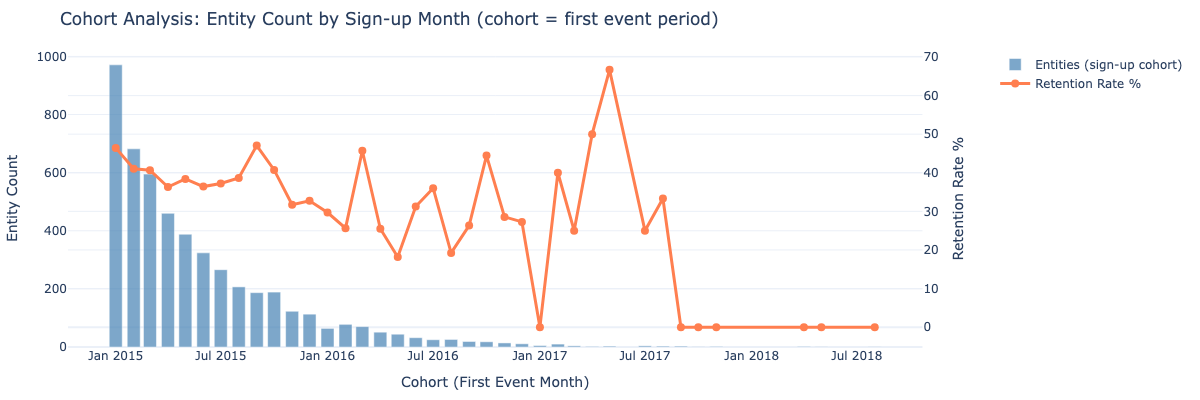

In [12]:
# Cohort Analysis - computation and visualization
from customer_retention.stages.profiling import analyze_cohort_distribution, generate_cohort_recommendations

COHORT_RECOMMENDATIONS = []
cohort_dist = None

if ENTITY_COLUMN:
    first_events = df.groupby(ENTITY_COLUMN)[TIME_COLUMN].min().reset_index()
    first_events.columns = [ENTITY_COLUMN, "first_event"]
    cohort_dist = analyze_cohort_distribution(first_events, "first_event")
    
    cohort_result = analyzer.analyze_cohorts(
        df, entity_column=ENTITY_COLUMN, cohort_column=TIME_COLUMN,
        target_column=TARGET_COLUMN, period="M"
    )
    
    print("👥 COHORT ANALYSIS")
    print("="*50)
    print(f"\nEntity Onboarding: {cohort_dist.dominant_pct:.0f}% in {cohort_dist.dominant_year}, {cohort_dist.num_years} years total")
    
    if len(cohort_result) > 0:
        cohort_sorted = cohort_result.sort_values("cohort")
        has_retention = "retention_rate" in cohort_sorted.columns
        
        fig = make_subplots(specs=[[{"secondary_y": True}]]) if has_retention else go.Figure()
        
        fig.add_trace(go.Bar(
            x=cohort_sorted["cohort"].astype(str), y=cohort_sorted["entity_count"],
            name="Entities (sign-up cohort)", marker_color="steelblue", opacity=0.7
        ), secondary_y=False) if has_retention else fig.add_trace(go.Bar(
            x=cohort_sorted["cohort"].astype(str), y=cohort_sorted["entity_count"],
            name="Entities (sign-up cohort)", marker_color="steelblue", opacity=0.7
        ))
        
        if has_retention:
            fig.add_trace(go.Scatter(
                x=cohort_sorted["cohort"].astype(str), y=cohort_sorted["retention_rate"] * 100,
                mode="lines+markers", name="Retention Rate %",
                line=dict(color="coral", width=3), marker=dict(size=8)
            ), secondary_y=True)
            fig.update_yaxes(title_text="Retention Rate %", secondary_y=True)
        
        fig.update_layout(
            title="Cohort Analysis: Entity Count by Sign-up Month (cohort = first event period)",
            xaxis_title="Cohort (First Event Month)", template="plotly_white", height=400
        )
        fig.update_yaxes(title_text="Entity Count", secondary_y=False) if has_retention else fig.update_yaxes(title_text="Entity Count")
        display_figure(fig)

In [13]:
# Cohort details and recommendations
if ENTITY_COLUMN and cohort_dist:
    retention_var = None
    if "retention_rate" in cohort_result.columns:
        retention_var = cohort_result["retention_rate"].max() - cohort_result["retention_rate"].min()
    
    cohort_recs = generate_cohort_recommendations(cohort_dist, retention_variation=retention_var)
    
    print("📊 COHORT DETAILS")
    print("="*50)
    print(f"\nEntity Onboarding Distribution by Year:")
    print("─" * 40)
    for year, count in sorted(cohort_dist.year_counts.items()):
        pct = count / cohort_dist.total_entities * 100
        bar = "█" * int(pct / 3)
        print(f"   {year}: {count:>5,} entities ({pct:>5.1f}%) {bar}")
    
    print(f"\n   Total entities: {cohort_dist.total_entities:,}")
    print(f"   Data spans: {df[TIME_COLUMN].min().date()} to {df[TIME_COLUMN].max().date()}")
    
    print("\n📋 RECOMMENDATIONS:")
    for rec in cohort_recs:
        priority_icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(rec.priority, "⚪")
        print(f"   {priority_icon} [{rec.priority.upper()}] {rec.action}")
        print(f"      {rec.reason}")
        if rec.features:
            print(f"      Features: {', '.join(rec.features)}")
        if rec.insight:
            print(f"      💡 {rec.insight}")
    
    COHORT_RECOMMENDATIONS = [{"action": r.action, "priority": r.priority, "reason": r.reason,
                               "features": getattr(r, 'features', []), 
                               "insight": getattr(r, 'insight', None)} for r in cohort_recs]

📊 COHORT DETAILS

Entity Onboarding Distribution by Year:
────────────────────────────────────────
   2015: 4,505 entities ( 90.1%) ██████████████████████████████
   2016:   452 entities (  9.0%) ███
   2017:    37 entities (  0.7%) 
   2018:     4 entities (  0.1%) 

   Total entities: 4,998
   Data spans: 2015-01-01 to 2022-09-26

📋 RECOMMENDATIONS:
   🟢 [LOW] skip_cohort_features
      90% onboarded in 2015 - insufficient variation
      💡 Established customer base, not a growing acquisition funnel
   🟡 [MEDIUM] investigate_cohort_retention
      Retention varies 67pp across cohorts - investigate drivers


## 1c.8 Correlation Matrix Analysis

**📊 Understanding Feature Relationships:**

This section shows feature-feature relationships in two complementary ways:
- **Correlation Matrix**: Numerical summary (r values)
- **Scatter Matrix**: Visual relationships with cohort overlay

| Correlation | Interpretation | Action |
|-------------|----------------|--------|
| `\|r\|` > 0.9 | Near-duplicate features | Remove one |
| `\|r\|` > 0.7 | Strong relationship | Consider combining |
| `\|r\|` < 0.3 | Weak/no relationship | Independent features |

Correlation Analysis (event-level, n=74,842)
  Included (5): ['opened', 'clicked', 'send_hour', 'bounced', 'time_to_open_hours']
  Excluded (2): ['target', 'target_entity']


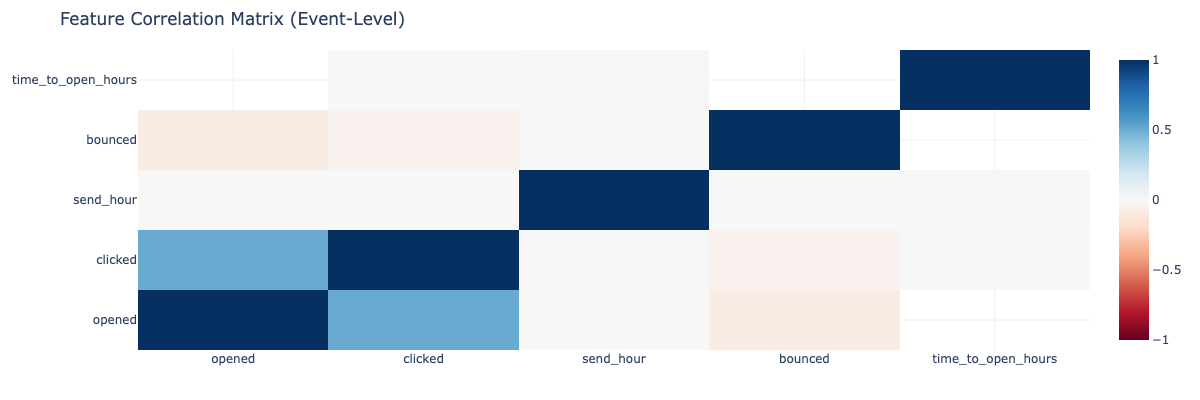

In [14]:
# Correlation matrix for numeric event attributes
# Define analysis columns - exclude entity, time, target, and temporal metadata
numeric_event_cols = [c for c in df.select_dtypes(include=[np.number]).columns 
                      if c not in [ENTITY_COLUMN, TIME_COLUMN, TARGET_COLUMN]
                      and c not in TEMPORAL_METADATA_COLS
                      and 'target' not in c.lower()]

excluded_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in numeric_event_cols]

print(f"Correlation Analysis (event-level, n={len(df):,})")
print(f"  Included ({len(numeric_event_cols)}): {numeric_event_cols}")
print(f"  Excluded ({len(excluded_cols)}): {excluded_cols}")

if len(numeric_event_cols) >= 2:
    corr_matrix = df[numeric_event_cols].corr()
    fig = charts.heatmap(
        corr_matrix.values, x_labels=numeric_event_cols, y_labels=numeric_event_cols,
        title="Feature Correlation Matrix (Event-Level)"
    )
    display_figure(fig)
    
    # High correlation pairs
    high_corr = []
    for i in range(len(numeric_event_cols)):
        for j in range(i+1, len(numeric_event_cols)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr.append((numeric_event_cols[i], numeric_event_cols[j], corr_val))
    
    if high_corr:
        print("\n⚠️ Highly correlated pairs (|r| > 0.7):")
        for c1, c2, r in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)[:5]:
            print(f"   {c1} ↔ {c2}: r={r:.2f}")


Scatter Matrix (n=1,000 entities)
  Total aggregated features: 15
  Selected (top 4 by variance): ['send_hour_sum', 'time_to_open_hours_sum', 'opened_sum', 'time_to_open_hours_mean']


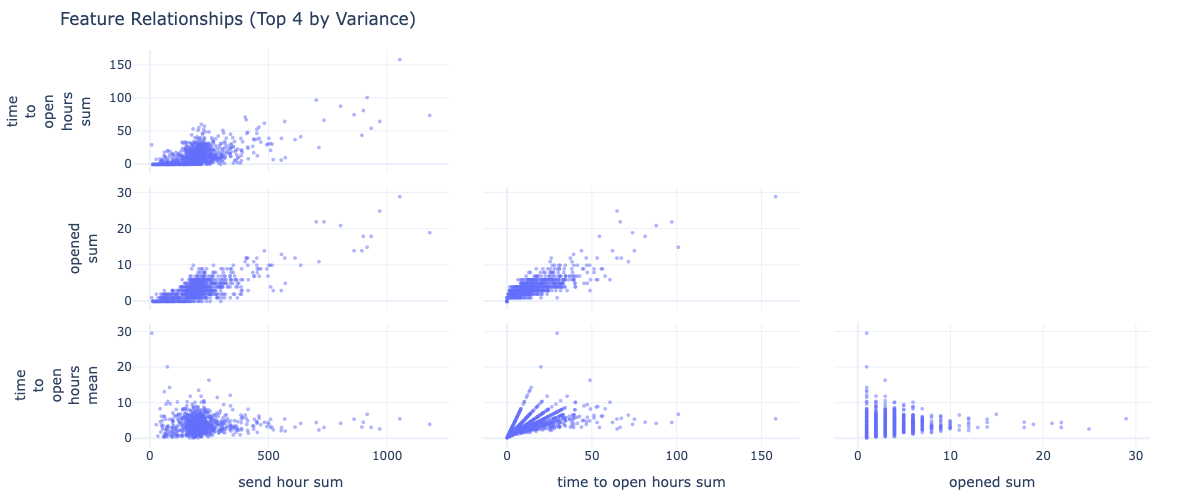


📈 Scatter Matrix Insights:
   • Different aggregation types create different patterns/bands
   • sum features often show exponential-like distributions
   • std features reveal variability clusters
   • mean features show central tendency patterns


In [15]:
# Scatter Matrix: Entity-level features (mixed aggregation types)
if len(numeric_event_cols) >= 2 and ENTITY_COLUMN and TARGET_COLUMN and TARGET_COLUMN in df.columns:
    # Create entity-level aggregations (mean, sum, std) - like original
    agg_dict = {col: ['mean', 'sum', 'std'] for col in numeric_event_cols}
    entity_aggs = df.groupby(ENTITY_COLUMN).agg(agg_dict)
    entity_aggs.columns = ['_'.join(col).strip() for col in entity_aggs.columns]
    entity_aggs = entity_aggs.reset_index()
    
    # Get all numeric aggregated columns
    all_agg_cols = [c for c in entity_aggs.columns if c != ENTITY_COLUMN]
    
    # Select top 4 by variance across ALL aggregation types
    variances = entity_aggs[all_agg_cols].var().sort_values(ascending=False)
    top_features = variances.head(4).index.tolist()
    
    # Sample if needed
    sample_size = min(1000, len(entity_aggs))
    scatter_sample = entity_aggs.sample(sample_size, random_state=42) if sample_size < len(entity_aggs) else entity_aggs
    
    print(f"Scatter Matrix (n={len(scatter_sample):,} entities)")
    print(f"  Total aggregated features: {len(all_agg_cols)}")
    print(f"  Selected (top 4 by variance): {top_features}")
    
    # Short labels for x-axis (no line breaks)
    short_labels = [f.replace('_', ' ') for f in top_features]
    
    scatter_data = scatter_sample[top_features].copy()
    scatter_data.columns = short_labels
    
    fig = charts.scatter_matrix(scatter_data, height=500)
    fig.update_traces(marker=dict(opacity=0.5, size=4))
    
    # Update y-axis labels to be multirow, keep x-axis single row
    n_features = len(short_labels)
    for i in range(n_features):
        # Y-axis: multirow
        yaxis_name = f'yaxis{i+1}' if i > 0 else 'yaxis'
        y_label = top_features[i].replace('_', '<br>')
        fig.update_layout(**{yaxis_name: dict(title=dict(text=y_label))})
        
        # X-axis: single row (spaces instead of underscores)
        xaxis_name = f'xaxis{i+1}' if i > 0 else 'xaxis'
        x_label = top_features[i].replace('_', ' ')
        fig.update_layout(**{xaxis_name: dict(title=dict(text=x_label))})
    
    fig.update_layout(
        title="Feature Relationships (Top 4 by Variance)",
        margin=dict(l=100, r=20, t=50, b=60)
    )
    
    display_figure(fig)
    
    print("\n📈 Scatter Matrix Insights:")
    print("   • Different aggregation types create different patterns/bands")
    print("   • sum features often show exponential-like distributions")
    print("   • std features reveal variability clusters")
    print("   • mean features show central tendency patterns")


In [16]:
# Correlation Analysis: Interpretation
print("\n" + "="*70)
print("CORRELATION ANALYSIS SUMMARY")
print("="*70)

if 'high_corr' in dir() and high_corr:
    print(f"\n📊 Found {len(high_corr)} highly correlated pairs (|r| > 0.7):")
    for c1, c2, r in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)[:5]:
        print(f"   • {c1} ↔ {c2}: r={r:.2f}")
    print("\n💡 RECOMMENDATIONS:")
    print("   → Remove redundant features to reduce multicollinearity")
    print("   → Or create composite features from correlated groups")
else:
    print("\n✅ No highly correlated pairs detected")
    print("   → Features appear independent, good for modeling")


CORRELATION ANALYSIS SUMMARY

✅ No highly correlated pairs detected
   → Features appear independent, good for modeling


## 1c.9 Temporal Sparklines

**📈 Understanding Temporal Trends:**

Sparklines show how numeric features evolve over time:

| Pattern | What It Means | Implication |
|---------|--------------|-------------|
| Upward trend | Metric increasing | Growth or engagement |
| Downward trend | Metric decreasing | Decline or churn signal |
| Flat line | Stable metric | Consistent behavior |
| Spikes | Sudden changes | Events or anomalies |


TEMPORAL SPARKLINES - COHORT × TIME PERIOD

5 features analyzed across Weekly/Monthly/Yearly periods


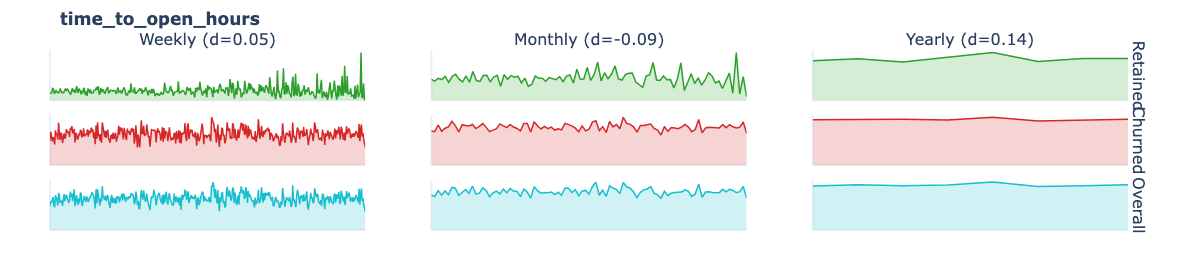

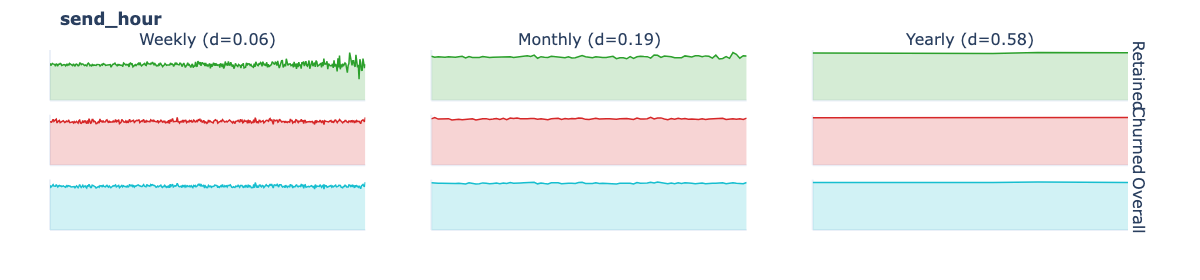

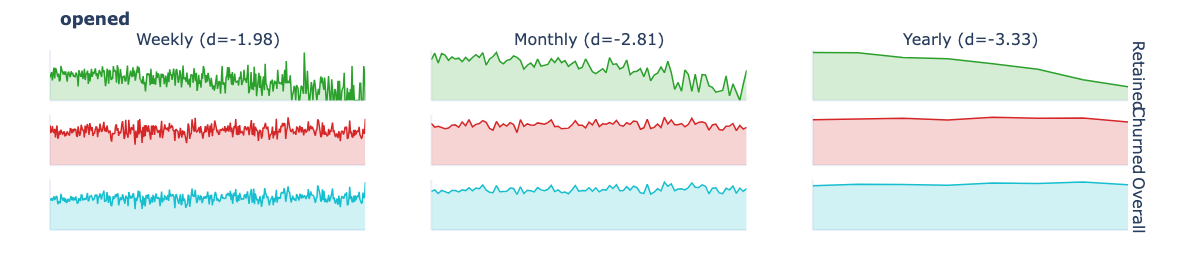

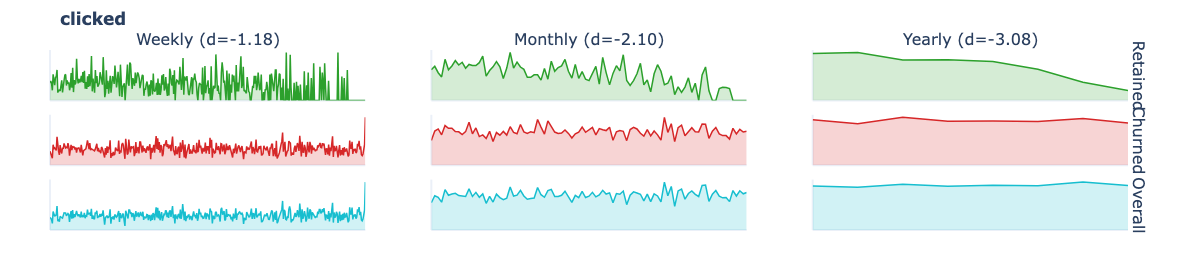

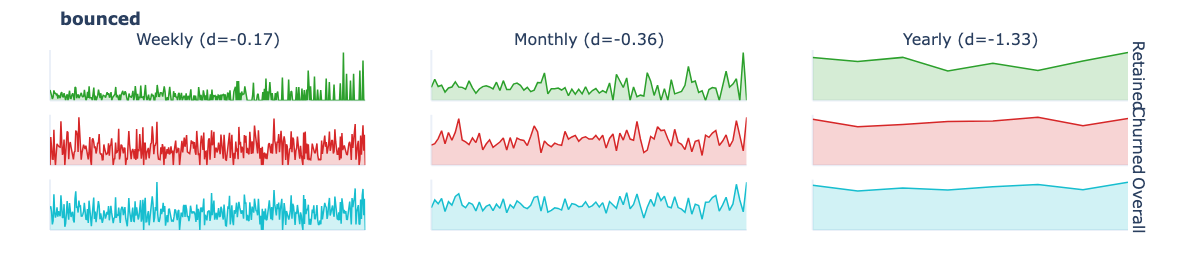


TREND & VARIANCE RECOMMENDATIONS

📈 Add Trend Features (opposite cohort trends):
   • time_to_open_hours: Opposite trends detected at yearly scale
     params: {period=yearly, method=slope}

📅 Add Time Indicators (seasonality detected):
   • time_to_open_hours: Seasonality detected at weekly scale
     params: {period=weekly, indicators=['cyclical_encoding']}
   • send_hour: Seasonality detected at weekly scale
     params: {period=weekly, indicators=['cyclical_encoding']}
   • opened: Seasonality detected at weekly scale
     params: {period=weekly, indicators=['cyclical_encoding']}
   • clicked: Seasonality detected at weekly scale
     params: {period=weekly, indicators=['cyclical_encoding']}
   • bounced: Seasonality detected at weekly scale
     params: {period=weekly, indicators=['cyclical_encoding']}

🔧 Apply Robust Scaling (high variance ratio):
   • time_to_open_hours: High variance ratio (11.4x) between cohorts
     params: {method=robust_scaler}


In [17]:
# Temporal Sparklines - Cohort × Time Period per feature with analysis
if len(numeric_event_cols) >= 2:
    variances = df[numeric_event_cols].var().sort_values(ascending=False)
    sparkline_cols = variances.index.tolist()
    
    print("\n" + "="*70)
    print("TEMPORAL SPARKLINES - COHORT × TIME PERIOD")
    print("="*70)
    print(f"\n{len(sparkline_cols)} features analyzed across Weekly/Monthly/Yearly periods")
    
    if ENTITY_COLUMN and TIME_COLUMN:
        df_spark = df.copy()
        df_spark['_week'] = pd.to_datetime(df_spark[TIME_COLUMN]).dt.to_period('W').dt.start_time
        df_spark['_month'] = pd.to_datetime(df_spark[TIME_COLUMN]).dt.to_period('M').dt.start_time
        df_spark['_year'] = pd.to_datetime(df_spark[TIME_COLUMN]).dt.to_period('Y').dt.start_time
        
        has_target = TARGET_COLUMN and TARGET_COLUMN in df.columns
        all_actions = []
        
        for col in sparkline_cols:
            if col not in df_spark.columns:
                continue
            
            feature_data = {}
            cohort_masks = ([("retained", df_spark[TARGET_COLUMN] == 1),
                            ("churned", df_spark[TARGET_COLUMN] == 0),
                            ("overall", slice(None))] if has_target 
                           else [("overall", slice(None))])
            
            for cohort, mask in cohort_masks:
                cohort_df = df_spark[mask] if isinstance(mask, pd.Series) else df_spark
                feature_data[cohort] = {
                    "weekly": cohort_df.groupby('_week')[col].mean().dropna().tolist(),
                    "monthly": cohort_df.groupby('_month')[col].mean().dropna().tolist(),
                    "yearly": cohort_df.groupby('_year')[col].mean().dropna().tolist(),
                }
            
            period_effects = None
            if has_target:
                analysis = charts.analyze_cohort_trends(feature_data, col)
                period_effects = {p: analysis["periods"][p]["effect_size"] 
                                  for p in analysis["periods"]}
                all_actions.extend(analysis.get("actions", []))
            
            fig = charts.cohort_sparklines(feature_data, feature_name=col, period_effects=period_effects)
            display_figure(fig)
        
        if has_target and all_actions:
            print("\n" + "="*70)
            print("TREND & VARIANCE RECOMMENDATIONS")
            print("="*70)
            
            BOLD, RESET = "\033[1m", "\033[0m"
            
            type_labels = {
                "add_trend_feature": "📈 Add Trend Features (opposite cohort trends)",
                "add_time_indicator": "📅 Add Time Indicators (seasonality detected)",
                "robust_scale": "🔧 Apply Robust Scaling (high variance ratio)",
                "normalize": "📊 Apply Normalization (high variance)",
            }
            
            by_type = {}
            for action in all_actions:
                action_type = action["action_type"]
                if action_type not in by_type:
                    by_type[action_type] = []
                by_type[action_type].append(action)
            
            for action_type, actions in by_type.items():
                print(f"\n{type_labels.get(action_type, action_type)}:")
                for a in actions:
                    params_str = ", ".join(f"{k}={v}" for k, v in a.get("params", {}).items())
                    print(f"   • {BOLD}{a['feature']}{RESET}: {a['reason']}")
                    if params_str:
                        print(f"     params: {{{params_str}}}")
else:
    print("Insufficient numeric columns for sparkline visualization")
# Store sparkline recommendations for pattern_summary
SPARKLINE_RECOMMENDATIONS = [
    {"action": a["action_type"], "feature": a["feature"], "reason": a["reason"],
     "params": a.get("params", {}), "priority": "high" if a["action_type"] == "add_trend_feature" else "medium",
     "features": [f"{a['feature']}_{a['action_type']}"]}
    for a in all_actions
] if 'all_actions' in dir() and all_actions else []


## 1c.10 Entity-Level Feature Analysis (Effect Sizes)

This section uses **three complementary approaches** to understand feature separation:

| Approach | What It Measures | Output |
|----------|------------------|--------|
| **Cohen's d** | Standardized mean difference | Single number per feature |
| **Correlation** | Linear relationship with target | Single number per feature |
| **Box Plots** | Full distribution by cohort | Visual comparison |

**📊 Cohen's d Interpretation:**

| `\|d\|` Value | Effect Size | Predictive Value |
|----------|-------------|------------------|
| ≥ 0.8 | Large | Strong differentiator |
| 0.5-0.8 | Medium | Useful signal |
| 0.2-0.5 | Small | Weak signal |
| < 0.2 | Negligible | Not predictive |

**Connection to Sparklines (1c.9):** The d values shown in the sparkline column headers are per-period effect sizes. Here we compute entity-level effect sizes across all aggregated features.

**See also:** Section 1c.8 for scatter matrix showing feature relationships with cohort overlay.

In [18]:
# Aggregate event data to entity level for effect size analysis
if ENTITY_COLUMN and TARGET_COLUMN and TARGET_COLUMN in df.columns:
    # Build entity-level aggregations
    entity_aggs = df.groupby(ENTITY_COLUMN).agg({
        TIME_COLUMN: ['count', 'min', 'max'],
        **{col: ['mean', 'sum', 'std'] for col in numeric_event_cols if col != TARGET_COLUMN}
    })
    entity_aggs.columns = ['_'.join(col).strip() for col in entity_aggs.columns]
    entity_aggs = entity_aggs.reset_index()
    
    # Add target
    entity_target = df.groupby(ENTITY_COLUMN)[TARGET_COLUMN].first().reset_index()
    entity_df = entity_aggs.merge(entity_target, on=ENTITY_COLUMN)
    
    # Add derived features
    entity_df['tenure_days'] = (entity_df[f'{TIME_COLUMN}_max'] - entity_df[f'{TIME_COLUMN}_min']).dt.days
    entity_df['event_count'] = entity_df[f'{TIME_COLUMN}_count']
    
    # Calculate effect sizes (Cohen's d) for entity-level features
    # Exclude entity, target, and temporal metadata columns
    effect_feature_cols = [c for c in entity_df.select_dtypes(include=[np.number]).columns
                          if c not in [ENTITY_COLUMN, TARGET_COLUMN]
                          and c not in TEMPORAL_METADATA_COLS]
    
    print("="*80)
    print("ENTITY-LEVEL FEATURE EFFECT SIZES (Cohen's d)")
    print("="*80)
    print(f"\nAnalyzing {len(effect_feature_cols)} aggregated features at entity level")
    print(f"Entities: {len(entity_df):,} (Retained: {(entity_df[TARGET_COLUMN]==1).sum():,}, Churned: {(entity_df[TARGET_COLUMN]==0).sum():,})\n")
    
    effect_sizes = []
    for col in effect_feature_cols:
        churned = entity_df[entity_df[TARGET_COLUMN] == 0][col].dropna()
        retained = entity_df[entity_df[TARGET_COLUMN] == 1][col].dropna()
        
        if len(churned) > 0 and len(retained) > 0:
            pooled_std = np.sqrt(((len(churned)-1)*churned.std()**2 + (len(retained)-1)*retained.std()**2) / 
                                 (len(churned) + len(retained) - 2))
            d = (retained.mean() - churned.mean()) / pooled_std if pooled_std > 0 else 0
            
            abs_d = abs(d)
            if abs_d >= 0.8:
                interp, emoji = "Large effect", "🔴"
            elif abs_d >= 0.5:
                interp, emoji = "Medium effect", "🟡"
            elif abs_d >= 0.2:
                interp, emoji = "Small effect", "🟢"
            else:
                interp, emoji = "Negligible", "⚪"
            
            effect_sizes.append({
                "feature": col, "cohens_d": d, "abs_d": abs_d, 
                "interpretation": interp, "emoji": emoji,
                "retained_mean": retained.mean(), "churned_mean": churned.mean()
            })
    
    # Sort and display
    effect_df = pd.DataFrame(effect_sizes).sort_values("abs_d", ascending=False)
    
    print(f"{'Feature':<35} {'d':>8} {'Effect':<15} {'Direction':<20}")
    print("-" * 80)
    for _, row in effect_df.head(15).iterrows():
        direction = "↑ Higher in retained" if row["cohens_d"] > 0 else "↓ Lower in retained"
        print(f"{row['emoji']} {row['feature'][:33]:<33} {row['cohens_d']:>+8.3f} {row['interpretation']:<15} {direction:<20}")
    
    # Categorize features
    large_effect = effect_df[effect_df["abs_d"] >= 0.8]["feature"].tolist()
    medium_effect = effect_df[(effect_df["abs_d"] >= 0.5) & (effect_df["abs_d"] < 0.8)]["feature"].tolist()
    small_effect = effect_df[(effect_df["abs_d"] >= 0.2) & (effect_df["abs_d"] < 0.5)]["feature"].tolist()
    
    # INTERPRETATION
    print("\n" + "─"*80)
    print("📖 INTERPRETATION & RECOMMENDATIONS")
    print("─"*80)
    
    if large_effect:
        print(f"\n🔴 LARGE EFFECT (|d| ≥ 0.8) - Priority Features:")
        for f in large_effect[:5]:
            row = effect_df[effect_df["feature"] == f].iloc[0]
            direction = "higher" if row["cohens_d"] > 0 else "lower"
            print(f"   • {f}: Retained customers have {direction} values")
            print(f"     Mean: Retained={row['retained_mean']:.2f}, Churned={row['churned_mean']:.2f}")
        print("   → MUST include in predictive model")
    
    if medium_effect:
        print(f"\n🟡 MEDIUM EFFECT (0.5 ≤ |d| < 0.8) - Useful Features:")
        for f in medium_effect[:3]:
            print(f"   • {f}")
        print("   → Should include in model")
    
    if small_effect:
        print(f"\n🟢 SMALL EFFECT (0.2 ≤ |d| < 0.5) - Supporting Features:")
        print(f"   {', '.join(small_effect[:5])}")
        print("   → May help in combination with other features")
    
    negligible = effect_df[effect_df["abs_d"] < 0.2]["feature"].tolist()
    if negligible:
        print(f"\n⚪ NEGLIGIBLE EFFECT (|d| < 0.2): {len(negligible)} features")
        print("   → Consider engineering or dropping from model")
else:
    print("Entity column or target not available for effect size analysis")

ENTITY-LEVEL FEATURE EFFECT SIZES (Cohen's d)

Analyzing 18 aggregated features at entity level
Entities: 4,998 (Retained: 1,973, Churned: 3,025)

Feature                                    d Effect          Direction           
--------------------------------------------------------------------------------
🔴 tenure_days                         -2.403 Large effect    ↓ Lower in retained 
🔴 opened_std                          -0.988 Large effect    ↓ Lower in retained 
🔴 opened_sum                          -0.915 Large effect    ↓ Lower in retained 
🔴 opened_mean                         -0.834 Large effect    ↓ Lower in retained 
🟡 feature_timestamp_count             -0.759 Medium effect   ↓ Lower in retained 
🟡 event_count                         -0.759 Medium effect   ↓ Lower in retained 
🟡 send_hour_sum                       -0.750 Medium effect   ↓ Lower in retained 
🟡 time_to_open_hours_sum              -0.743 Medium effect   ↓ Lower in retained 
🟡 clicked_sum                     

DISTRIBUTION COMPARISON: Retained vs Churned (Box Plots)

📊 Showing top 6 features by effect size
   🟢 Green = Retained | 🔴 Red = Churned



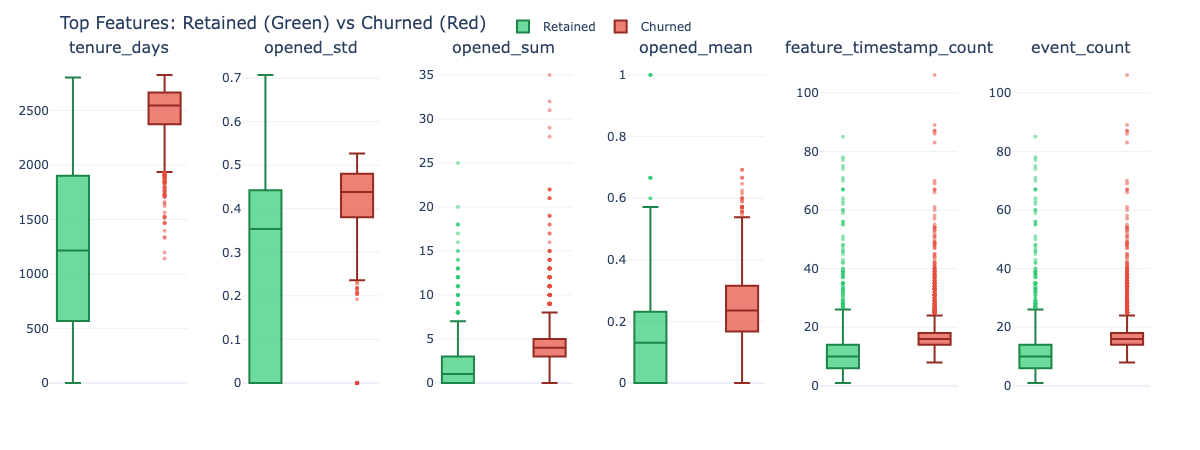

──────────────────────────────────────────────────────────────────────
📖 HOW TO READ BOX PLOTS
──────────────────────────────────────────────────────────────────────

Box Plot Elements:
  • Box = Middle 50% of data (IQR: 25th to 75th percentile)
  • Line inside box = Median (50th percentile)
  • Whiskers = 1.5 × IQR from box edges
  • Dots outside = Outliers

What makes a good predictor:
  ✓ Clear SEPARATION between green and red boxes
  ✓ Different MEDIANS (center lines at different heights)
  ✓ Minimal OVERLAP between boxes

Patterns to look for:
  • Green box entirely above red → Retained have higher values
  • Green box entirely below red → Retained have lower values
  • Overlapping boxes → Feature alone may not discriminate well
  • Many outliers in one group → Subpopulations worth investigating



In [19]:
# Box Plots: Entity-level feature distributions by target
if ENTITY_COLUMN and TARGET_COLUMN and 'entity_df' in dir() and len(effect_df) > 0:
    # Select top features by effect size for visualization
    top_features = effect_df.head(6)["feature"].tolist()
    n_features = len(top_features)
    
    if n_features > 0:
        print("="*70)
        print("DISTRIBUTION COMPARISON: Retained vs Churned (Box Plots)")
        print("="*70)
        print("\n📊 Showing top 6 features by effect size")
        print("   🟢 Green = Retained | 🔴 Red = Churned\n")
        
        fig = make_subplots(rows=1, cols=n_features, subplot_titles=top_features, horizontal_spacing=0.05)
        
        for i, col in enumerate(top_features):
            col_num = i + 1
            
            # Retained (1) - Green
            retained_data = entity_df[entity_df[TARGET_COLUMN] == 1][col].dropna()
            fig.add_trace(go.Box(y=retained_data, name='Retained',
                fillcolor='rgba(46, 204, 113, 0.7)', line=dict(color='#1e8449', width=2),
                boxpoints='outliers', width=0.35, showlegend=(i == 0), legendgroup='retained',
                marker=dict(color='rgba(46, 204, 113, 0.5)', size=4)), row=1, col=col_num)
            
            # Churned (0) - Red
            churned_data = entity_df[entity_df[TARGET_COLUMN] == 0][col].dropna()
            fig.add_trace(go.Box(y=churned_data, name='Churned',
                fillcolor='rgba(231, 76, 60, 0.7)', line=dict(color='#922b21', width=2),
                boxpoints='outliers', width=0.35, showlegend=(i == 0), legendgroup='churned',
                marker=dict(color='rgba(231, 76, 60, 0.5)', size=4)), row=1, col=col_num)
        
        fig.update_layout(height=450, title_text="Top Features: Retained (Green) vs Churned (Red)",
            template='plotly_white', showlegend=True, boxmode='group',
            legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="center", x=0.5))
        fig.update_xaxes(showticklabels=False)
        display_figure(fig)
        
        # INTERPRETATION
        print("─"*70)
        print("📖 HOW TO READ BOX PLOTS")
        print("─"*70)
        print("""
Box Plot Elements:
  • Box = Middle 50% of data (IQR: 25th to 75th percentile)
  • Line inside box = Median (50th percentile)
  • Whiskers = 1.5 × IQR from box edges
  • Dots outside = Outliers

What makes a good predictor:
  ✓ Clear SEPARATION between green and red boxes
  ✓ Different MEDIANS (center lines at different heights)
  ✓ Minimal OVERLAP between boxes

Patterns to look for:
  • Green box entirely above red → Retained have higher values
  • Green box entirely below red → Retained have lower values
  • Overlapping boxes → Feature alone may not discriminate well
  • Many outliers in one group → Subpopulations worth investigating
""")

FEATURE-TARGET CORRELATIONS (Entity-Level)


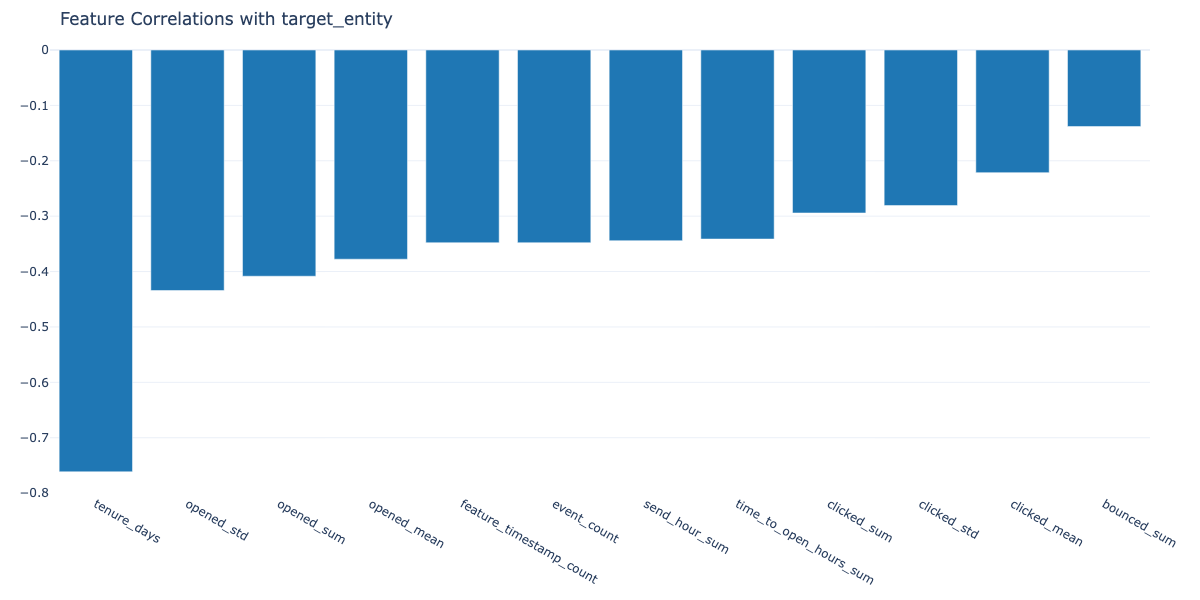


📊 Correlation Rankings:
Feature                              Correlation Strength        Direction
---------------------------------------------------------------------------
tenure_days                               -0.761 Strong          Negative
opened_std                                -0.434 Moderate        Negative
opened_sum                                -0.408 Moderate        Negative
opened_mean                               -0.378 Moderate        Negative
feature_timestamp_count                   -0.348 Moderate        Negative
event_count                               -0.348 Moderate        Negative
send_hour_sum                             -0.344 Moderate        Negative
time_to_open_hours_sum                    -0.341 Moderate        Negative
clicked_sum                               -0.294 Weak            Negative
clicked_std                               -0.281 Weak            Negative

──────────────────────────────────────────────────────────────────────
📖 INTERPRETI

In [20]:
# Feature-Target Correlation Ranking
if ENTITY_COLUMN and TARGET_COLUMN and 'entity_df' in dir():
    print("="*70)
    print("FEATURE-TARGET CORRELATIONS (Entity-Level)")
    print("="*70)
    
    correlations = []
    for col in effect_feature_cols:
        if col != TARGET_COLUMN:
            corr = entity_df[[col, TARGET_COLUMN]].corr().iloc[0, 1]
            if not np.isnan(corr):
                correlations.append({"Feature": col, "Correlation": corr})
    
    if correlations:
        corr_df = pd.DataFrame(correlations).sort_values("Correlation", key=abs, ascending=False)
        
        fig = charts.bar_chart(
            corr_df["Feature"].head(12).tolist(),
            corr_df["Correlation"].head(12).tolist(),
            title=f"Feature Correlations with {TARGET_COLUMN}"
        )
        display_figure(fig)
        
        print("\n📊 Correlation Rankings:")
        print(f"{'Feature':<35} {'Correlation':>12} {'Strength':<15} {'Direction'}")
        print("-" * 75)
        
        for _, row in corr_df.head(10).iterrows():
            abs_corr = abs(row["Correlation"])
            if abs_corr >= 0.5:
                strength = "Strong"
            elif abs_corr >= 0.3:
                strength = "Moderate"
            elif abs_corr >= 0.1:
                strength = "Weak"
            else:
                strength = "Very weak"
            
            direction = "Positive" if row["Correlation"] > 0 else "Negative"
            print(f"{row['Feature'][:34]:<35} {row['Correlation']:>+12.3f} {strength:<15} {direction}")
        
        # INTERPRETATION
        print("\n" + "─"*70)
        print("📖 INTERPRETING CORRELATIONS WITH TARGET")
        print("─"*70)
        print("""
Correlation with binary target (retained=1, churned=0):

  Positive correlation (+): Higher values → more likely RETAINED
  Negative correlation (-): Higher values → more likely CHURNED

Strength guide:
  |r| > 0.5:  Strong - prioritize this feature
  |r| 0.3-0.5: Moderate - useful predictor
  |r| 0.1-0.3: Weak - may help in combination
  |r| < 0.1:  Very weak - limited predictive value

Note: Correlation captures LINEAR relationships only.
Non-linear relationships may have low correlation but still be predictive.
""")

In [21]:
# Entity-Level Analysis: Summary
print("\n" + "="*70)
print("ENTITY-LEVEL FEATURE SUMMARY")
print("="*70)

if 'effect_df' in dir() and len(effect_df) > 0:
    large_effects = effect_df[effect_df['cohens_d'].abs() >= 0.5]
    print(f"\n📊 Effect Size Summary:")
    print(f"   • Total features analyzed: {len(effect_df)}")
    print(f"   • Features with |d| ≥ 0.5 (medium+): {len(large_effects)}")
    print(f"   • Features with |d| < 0.2 (negligible): {(effect_df['cohens_d'].abs() < 0.2).sum()}")
    
    if len(large_effects) > 0:
        print("\n   Top differentiators:")
        for _, row in large_effects.head(5).iterrows():
            direction = "↑ higher in retained" if row['cohens_d'] > 0 else "↓ lower in retained"
            print(f"   • \033[1m{row['feature']}\033[0m: d={row['cohens_d']:+.2f} ({direction})")
    
    print("\n📋 What the Three Approaches Showed:")
    print("   • Cohen's d → identified features with strongest mean separation")
    print("   • Correlation → confirmed linear relationship direction")
    print("   • Box plots → revealed distribution shapes and outliers")
    
    print("\n💡 RECOMMENDATIONS:")
    print("   → Prioritize features with |d| > 0.5 in model")
    print("   → Consider dropping features with |d| < 0.2")
    print("   → Check box plots for non-normal distributions that may need transformation")
else:
    print("\n⚠️ Effect size analysis not performed")

# Store effect size recommendations for pattern_summary
EFFECT_SIZE_RECOMMENDATIONS = []
if 'effect_df' in dir() and len(effect_df) > 0:
    for _, row in effect_df.iterrows():
        abs_d = abs(row['cohens_d'])
        if abs_d >= 0.5:
            EFFECT_SIZE_RECOMMENDATIONS.append({
                "action": "prioritize_feature", "feature": row['feature'],
                "effect_size": row['cohens_d'], "priority": "high" if abs_d >= 0.8 else "medium",
                "reason": f"Cohen's d={row['cohens_d']:.2f} shows {'large' if abs_d >= 0.8 else 'medium'} effect",
                "features": [row['feature']]
            })
        elif abs_d < 0.2:
            EFFECT_SIZE_RECOMMENDATIONS.append({
                "action": "consider_dropping", "feature": row['feature'],
                "effect_size": row['cohens_d'], "priority": "low",
                "reason": f"Cohen's d={row['cohens_d']:.2f} shows negligible effect",
                "features": []  # No feature to add, just informational
            })



ENTITY-LEVEL FEATURE SUMMARY

📊 Effect Size Summary:
   • Total features analyzed: 18
   • Features with |d| ≥ 0.5 (medium+): 10
   • Features with |d| < 0.2 (negligible): 5

   Top differentiators:
   • tenure_days: d=-2.40 (↓ lower in retained)
   • opened_std: d=-0.99 (↓ lower in retained)
   • opened_sum: d=-0.92 (↓ lower in retained)
   • opened_mean: d=-0.83 (↓ lower in retained)
   • feature_timestamp_count: d=-0.76 (↓ lower in retained)

📋 What the Three Approaches Showed:
   • Cohen's d → identified features with strongest mean separation
   • Correlation → confirmed linear relationship direction
   • Box plots → revealed distribution shapes and outliers

💡 RECOMMENDATIONS:
   → Prioritize features with |d| > 0.5 in model
   → Consider dropping features with |d| < 0.2
   → Check box plots for non-normal distributions that may need transformation


## 1c.11 Recency Analysis

**📖 What is Recency?**
Days since each entity's last event. A key predictor in churn models.

**📊 How to Read the Panel:**
- **Top Row**: Distribution histograms for Retained vs Churned
  - Compare shapes: Similar = weak signal, Different = strong signal
  - Compare medians: Large gap = recency discriminates well
- **Bottom Left**: Target rate by recency bucket
  - Look for: Monotonic decline, sharp thresholds, or flat patterns
  - Inflection points suggest where to create binary flags

**✅ Pattern Interpretation:**
| Pattern | Meaning | Feature Strategy |
|---------|---------|------------------|
| Monotonic decline | Gradual disengagement | Use continuous recency |
| Threshold/step | Clear activity boundary | Create binary is_active_Nd flag |
| Flat | Recency not predictive | May omit or use only in combination |

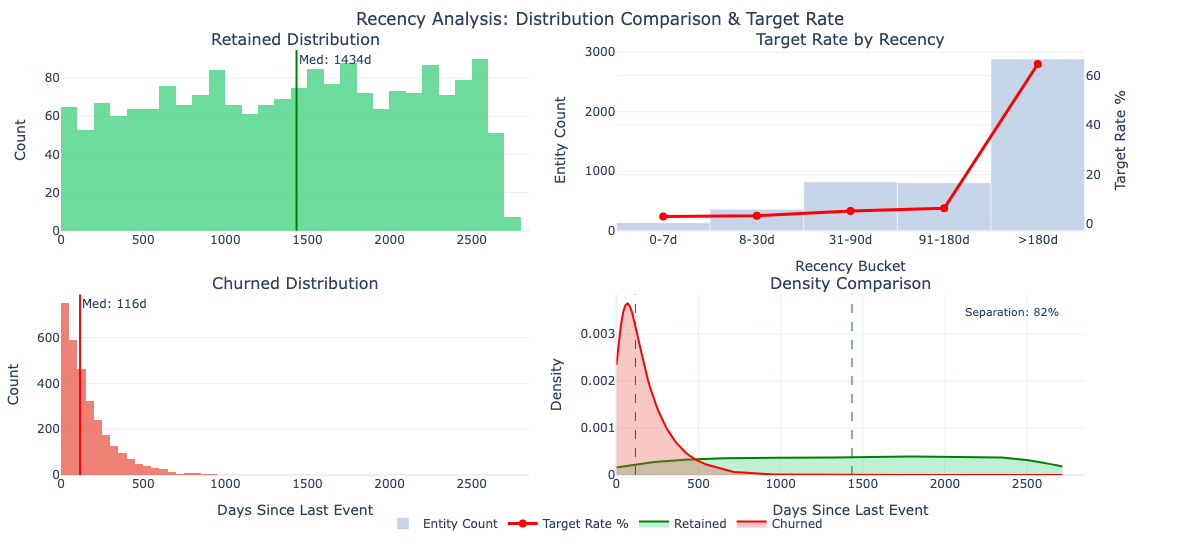

#### KEY FINDINGS  
*(i) Churned entities last active 1318 days shorter than retained (median: 116d vs 1434d)*  
*(i) ⚠️ Unusual pattern: churned have MORE recent activity. Target=1 is minority (39%) - likely means CHURN not retention.*  
*(i) Recency strongly discriminates target (Large effect, d=+2.23) - high predictive value*

Metric              Retained      Churned         Diff
----------------------------------------------------
Mean                  1399.3        164.7      -1234.7
Median                1434.0        116.0      -1318.0
Std Dev                767.1        160.5       -606.6


#### DETAILED STATISTICS  
Retained (n): **1,923**  
Churned (n): **3,025**  
Effect Size: **+2.23 (Large effect)**  
Pattern: **Variable**

#### ACTIONABLE RECOMMENDATIONS  
*(i) 🔴 [HIGH] Invert Target Interpretation*  
*(i)    Target=1 is minority (39%) - interpret as CHURN; recency pattern is classic churn behavior*  
Features: **days_since_last_event, log_recency**

In [22]:
# Recency Analysis - Combined visualization and insights
from customer_retention.analysis.visualization import console
from customer_retention.stages.profiling import compare_recency_by_target

recency_comparison = None
recency_result = None
RECENCY_RECOMMENDATIONS = []

if ENTITY_COLUMN:
    reference_date = df[TIME_COLUMN].max()
    
    # Compute recency_result for use in summary cells
    recency_result = analyzer.analyze_recency(df, ENTITY_COLUMN, TARGET_COLUMN, reference_date)
    
    if TARGET_COLUMN and TARGET_COLUMN in df.columns:
        recency_comparison = compare_recency_by_target(
            df, ENTITY_COLUMN, TIME_COLUMN, TARGET_COLUMN, reference_date
        )
    
    if recency_comparison:
        # Combined visualization panel
        entity_last = df.groupby(ENTITY_COLUMN)[TIME_COLUMN].max().reset_index()
        entity_last["recency_days"] = (reference_date - entity_last[TIME_COLUMN]).dt.days
        entity_target = df.groupby(ENTITY_COLUMN)[TARGET_COLUMN].first().reset_index()
        entity_recency = entity_last.merge(entity_target, on=ENTITY_COLUMN)
        cap = entity_recency["recency_days"].quantile(0.99)
        entity_capped = entity_recency[entity_recency["recency_days"] <= cap]
        
        retained = entity_capped[entity_capped[TARGET_COLUMN] == 1]["recency_days"].values
        churned = entity_capped[entity_capped[TARGET_COLUMN] == 0]["recency_days"].values
        
        fig = charts.recency_analysis_panel(
            retained_recency=retained,
            churned_recency=churned,
            bucket_stats=recency_comparison.bucket_stats,
            retained_median=recency_comparison.retained_stats.median,
            churned_median=recency_comparison.churned_stats.median,
            cap_value=cap
        )
        display_figure(fig)
        
        # Key Findings
        console.start_section()
        console.header("Key Findings")
        for insight in recency_comparison.key_findings:
            console.info(insight.finding)
        console.end_section()
        
        # Statistics
        ret, churn = recency_comparison.retained_stats, recency_comparison.churned_stats
        console.start_section()
        console.header("Detailed Statistics")
        console.metric("Retained (n)", f"{ret.count:,}")
        console.metric("Churned (n)", f"{churn.count:,}")
        print(f"{'Metric':<15} {'Retained':>12} {'Churned':>12} {'Diff':>12}")
        print("-" * 52)
        for name, r, c in [("Mean", ret.mean, churn.mean), ("Median", ret.median, churn.median), 
                           ("Std Dev", ret.std, churn.std)]:
            print(f"{name:<15} {r:>12.1f} {c:>12.1f} {c-r:>+12.1f}")
        console.metric("Effect Size", f"{recency_comparison.cohens_d:+.2f} ({recency_comparison.effect_interpretation})")
        console.metric("Pattern", recency_comparison.distribution_pattern.replace("_", " ").title())
        if recency_comparison.inflection_bucket:
            console.metric("Inflection", recency_comparison.inflection_bucket)
        console.end_section()
        
        # Actionable Recommendations
        console.start_section()
        console.header("Actionable Recommendations")
        RECENCY_RECOMMENDATIONS = recency_comparison.recommendations
        for rec in RECENCY_RECOMMENDATIONS:
            priority = rec.get("priority", "medium")
            priority_icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(priority, "⚪")
            console.info(f"{priority_icon} [{priority.upper()}] {rec['action'].replace('_', ' ').title()}")
            console.info(f"   {rec['reason']}")
            if rec.get("features"):
                console.metric("Features", ", ".join(rec["features"]))
        console.end_section()
    else:
        # No target - show basic recency distribution
        entity_last = df.groupby(ENTITY_COLUMN)[TIME_COLUMN].max().reset_index()
        entity_last["recency_days"] = (reference_date - entity_last[TIME_COLUMN]).dt.days
        median_recency = entity_last["recency_days"].median()
        cap = entity_last["recency_days"].quantile(0.99)
        capped = entity_last[entity_last["recency_days"] <= cap]
        
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=capped["recency_days"], nbinsx=50, marker_color="coral", opacity=0.7))
        fig.add_vline(x=median_recency, line_dash="solid", line_color="green", annotation_text=f"Median: {median_recency:.0f} days")
        fig.update_layout(title=f"Recency Distribution (capped at {cap:.0f} days)", xaxis_title="Days Since Last Event", yaxis_title="Count", template="plotly_white", height=400)
        display_figure(fig)
        
        console.start_section()
        console.header("Recency Statistics")
        console.metric("Median", f"{median_recency:.0f} days")
        console.metric("Mean", f"{entity_last['recency_days'].mean():.0f} days")
        console.info("No target column - cannot compare retained vs churned")
        console.end_section()

## 1c.12 Velocity & Acceleration Analysis

**📖 Why Velocity and Acceleration Matter:**

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| **Velocity** | Δ(value) / Δt | Rate of change - is activity speeding up or slowing down? |
| **Acceleration** | Δ(velocity) / Δt | Change in rate - is the slowdown accelerating? |

**📊 Analysis Approach:**

1. **Signal Heatmap**: Effect sizes (Cohen's d) across variable × time window combinations
   - Shows cohort separation strength at each time scale
   - Higher |d| = stronger individual signal, but low |d| features may still help in combinations
   
2. **Detailed Sparklines**: For top features (ranked by max |d| across windows)
   - Shows ALL time windows for each feature - different scales capture different dynamics
   - Retained vs churned velocity/acceleration side by side


VELOCITY & ACCELERATION SIGNAL ANALYSIS
Analyzing 2 features across windows: [7, 14, 30, 90, 180, 365] days


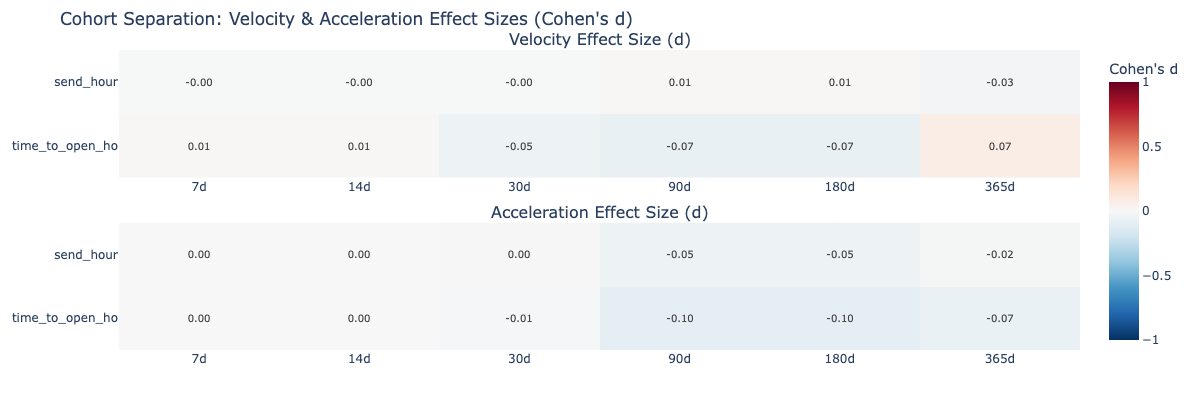


DETAILED SPARKLINES (top features)


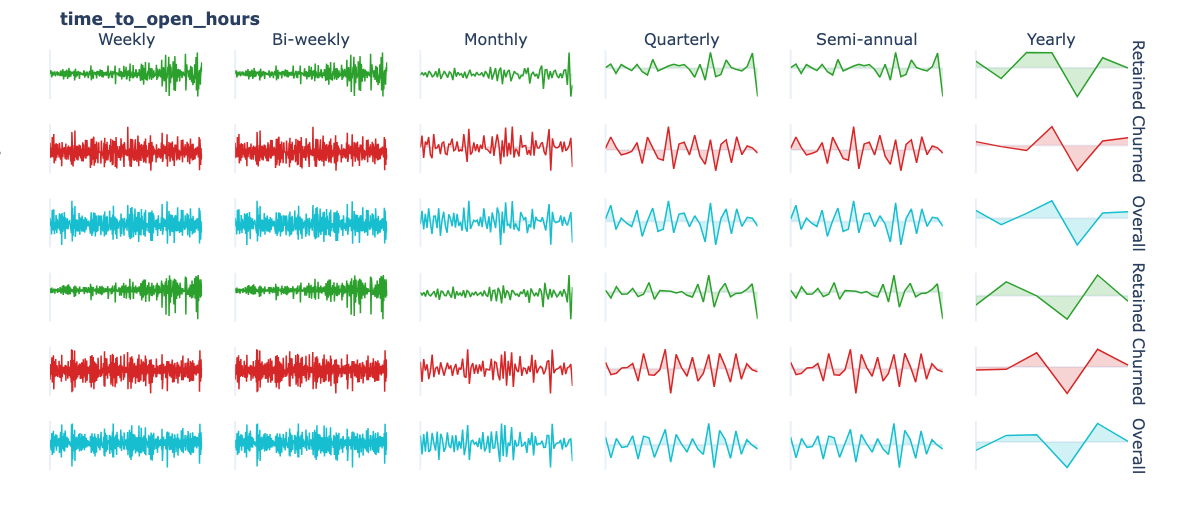

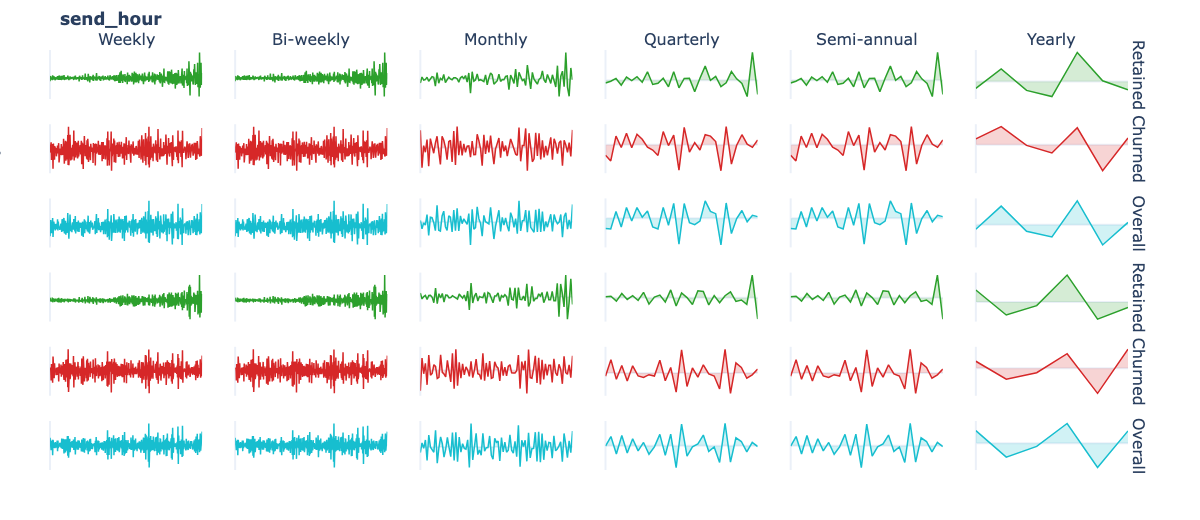


──────────────────────────────────────────────────────────────────────
📖 INTERPRETATION
──────────────────────────────────────────────────────────────────────

Velocity measures rate of change; acceleration measures change in rate.
Positive d: retained > churned | Negative d: churned > retained
|d| ≥ 0.8: large effect | ≥ 0.5: medium | ≥ 0.2: small

• time_to_open_hours: No significant velocity difference between cohorts
• send_hour: No significant velocity difference between cohorts

──────────────────────────────────────────────────────────────────────
🎯 FEATURE RECOMMENDATIONS
──────────────────────────────────────────────────────────────────────

No velocity/acceleration features recommended (no strong signals found).


In [23]:
# Velocity & Acceleration Cohort Analysis with Effect Size Heatmap
if ENTITY_COLUMN and TARGET_COLUMN and sparkline_cols:
    continuous_cols = [c for c in sparkline_cols if df[c].nunique() > 2][:6]
    
    if not continuous_cols:
        print("⚠️ No continuous numeric columns found for velocity analysis.")
    else:
        print("="*70)
        print("VELOCITY & ACCELERATION SIGNAL ANALYSIS")
        print("="*70)
        
        if 'feature_analyzer' not in dir():
            feature_analyzer = TemporalFeatureAnalyzer(time_column=TIME_COLUMN, entity_column=ENTITY_COLUMN)
        
        windows = [7, 14, 30, 90, 180, 365]
        print(f"Analyzing {len(continuous_cols)} features across windows: {windows} days")
        
        all_results = {}
        heatmap_data = {"velocity": {}, "acceleration": {}}
        
        for col in continuous_cols:
            results = feature_analyzer.compute_cohort_velocity_signals(
                df, [col], TARGET_COLUMN, windows=windows
            )
            all_results[col] = results[col]
            heatmap_data["velocity"][col] = {f"{r.window_days}d": r.velocity_effect_size for r in results[col]}
            heatmap_data["acceleration"][col] = {f"{r.window_days}d": r.accel_effect_size for r in results[col]}
        
        fig = charts.velocity_signal_heatmap(heatmap_data, title="Cohort Separation: Velocity & Acceleration Effect Sizes (Cohen's d)")
        display_figure(fig)
        
        print("\n" + "="*70)
        print("DETAILED SPARKLINES (top features)")
        print("="*70)
        
        feature_max_d = [(col, max(abs(r.velocity_effect_size) for r in results)) 
                         for col, results in all_results.items()]
        feature_max_d.sort(key=lambda x: -x[1])
        
        top_features = [col for col, _ in feature_max_d[:3]]
        for col in top_features:
            fig = charts.cohort_velocity_sparklines(all_results[col], feature_name=col)
            display_figure(fig)
        
        print("\n" + "─"*70)
        print("📖 INTERPRETATION")
        print("─"*70)
        print("\nVelocity measures rate of change; acceleration measures change in rate.")
        print("Positive d: retained > churned | Negative d: churned > retained")
        print("|d| ≥ 0.8: large effect | ≥ 0.5: medium | ≥ 0.2: small\n")
        
        interpretation_notes = feature_analyzer.generate_velocity_interpretation(all_results)
        for note in interpretation_notes:
            print(note)
        
        print("\n" + "─"*70)
        print("🎯 FEATURE RECOMMENDATIONS")
        print("─"*70)
        
        velocity_recs = feature_analyzer.generate_velocity_recommendations(all_results)
        if velocity_recs:
            for rec in velocity_recs:
                priority_marker = "🔴" if rec.priority == 1 else "🟡"
                print(f"\n{priority_marker} {rec.action.upper()}")
                print(f"   Column: {rec.source_column}")
                print(f"   {rec.description}")
                print(f"   Params: {rec.params}")
        else:
            print("\nNo velocity/acceleration features recommended (no strong signals found).")

# Store velocity recommendations for pattern_summary
VELOCITY_RECOMMENDATIONS = [{"action": r.action, "source_column": r.source_column, 
                              "description": r.description, "priority": r.priority,
                              "effect_size": r.effect_size, "params": r.params,
                              "features": [f"{r.source_column}_velocity_{r.params.get('window_days', 7)}d"]}
                             for r in velocity_recs] if velocity_recs else []


## 1c.13 Momentum Analysis (Window Ratios)

**📖 What is Momentum?**

Momentum compares recent activity to historical activity for each customer:

```
Momentum = mean(value over last N days) / mean(value over last M days)
```

Where N < M (e.g., 7d/30d compares last week to last month).

| Momentum Value | Interpretation |
|----------------|----------------|
| > 1.0 | Recent activity higher than historical → engagement increasing |
| < 1.0 | Recent activity lower than historical → potential churn signal |
| ≈ 1.0 | Stable behavior |

**Window Pairs Analyzed:**
- **Natural pairs** (week/month/quarter): 7d/30d, 30d/90d, 7d/90d
- **Recommended pairs** from `pattern_config` (based on 01a aggregation windows)
- **Accumulation pair**: recent activity vs all-time behavior


MOMENTUM ANALYSIS (Window Ratios)
Analyzing 5 features across 5 window pairs:
  Natural pairs (week/month/quarter): [(7, 30), (30, 90), (7, 90)]
  Recommended pairs (from 01a): [(180, 365)]
  Accumulation pair: 7d vs all-time (2825d)
  Combined (deduplicated): 5 pairs



📊 Momentum by Cohort:
Feature            Window         Retained    Churned   Effect d
--------------------------------------------------------------
time_to_open_hour  7d/30d             1.00       0.97       0.00
time_to_open_hour  30d/90d            1.00       0.99       0.16
time_to_open_hour  7d/90d             1.00       0.97       0.00
time_to_open_hour  180d/365d          1.10       1.00       0.34
time_to_open_hour  7d/all             1.00       0.67       0.00
send_hour          7d/30d             0.95       0.99      -0.45
send_hour          30d/90d            1.00       1.01      -0.03
send_hour          7d/90d             0.95       0.99      -0.26
send_hour          180d/365d          1.01       1.00       0.07
send_hour          7d/all             1.00       0.99       0.05
opened             7d/30d             0.00       1.04       0.00
opened             30d/90d            1.50       0.90       1.01
opened             7d/90d             0.00       0.96       0.00
open

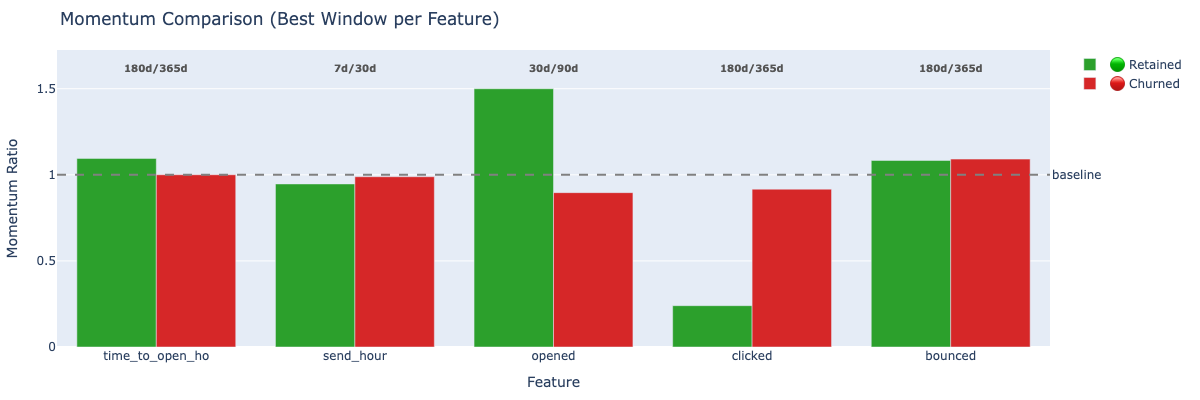


──────────────────────────────────────────────────────────────────────
📖 INTERPRETATION
──────────────────────────────────────────────────────────────────────

Momentum = recent_mean / historical_mean (per entity, then averaged)
> 1.0 = accelerating | < 1.0 = decelerating | ≈ 1.0 = stable
|d| measures how differently retained vs churned customers behave

• time_to_open_hours: Moderate signal at 180d/365d (d=0.34) - retained=1.10, churned=1.00
• send_hour: Moderate signal at 7d/30d (d=-0.45) - retained=0.95, churned=0.99
• opened: Strong signal at 30d/90d - retained accelerating (1.50), churned decelerating (0.90), d=1.01
• clicked: Strong signal at 180d/365d - retained decelerating (0.24), churned decelerating (0.92), d=-0.97
• bounced: No significant momentum difference between cohorts

──────────────────────────────────────────────────────────────────────
🎯 FEATURE RECOMMENDATIONS
──────────────────────────────────────────────────────────────────────

🔴 ADD_MOMENTUM_FEATURE
   Colum

In [24]:
# Momentum Analysis - Cohort Comparison
if ENTITY_COLUMN and TARGET_COLUMN and sparkline_cols:
    print("="*70)
    print("MOMENTUM ANALYSIS (Window Ratios)")
    print("="*70)
    
    if 'feature_analyzer' not in dir():
        feature_analyzer = TemporalFeatureAnalyzer(time_column=TIME_COLUMN, entity_column=ENTITY_COLUMN)
    
    # Use sparkline_cols directly (includes all numeric features ranked by variance)
    momentum_cols = sparkline_cols[:6]
    
    # Build comprehensive window pairs from multiple sources:
    # 1. Standard natural pairs (week/month/quarter)
    natural_pairs = [(7, 30), (30, 90), (7, 90)]
    
    # 2. Recommended pairs from pattern_config (based on 01a aggregation windows)
    recommended_pairs = pattern_config.get_momentum_pairs()
    
    # 3. Accumulation pair: shortest window vs all-time
    max_days = (df[TIME_COLUMN].max() - df[TIME_COLUMN].min()).days
    all_windows = [w for pair in natural_pairs + recommended_pairs for w in pair]
    shortest_window = min(all_windows) if all_windows else 7
    accumulation_pair = (shortest_window, max_days)
    
    # Combine and deduplicate (preserve order: natural first, then recommended, then accumulation)
    seen = set()
    window_pairs = []
    for pair in natural_pairs + recommended_pairs + [accumulation_pair]:
        if pair not in seen:
            window_pairs.append(pair)
            seen.add(pair)
    
    print(f"Analyzing {len(momentum_cols)} features across {len(window_pairs)} window pairs:")
    print(f"  Natural pairs (week/month/quarter): {natural_pairs}")
    print(f"  Recommended pairs (from 01a): {recommended_pairs}")
    print(f"  Accumulation pair: {shortest_window}d vs all-time ({max_days}d)")
    print(f"  Combined (deduplicated): {len(window_pairs)} pairs")
    
    all_momentum_results = {}
    for col in momentum_cols:
        results = feature_analyzer.compute_cohort_momentum_signals(
            df, [col], TARGET_COLUMN, window_pairs=window_pairs
        )
        all_momentum_results[col] = results[col]
    
    print("\n📊 Momentum by Cohort:")
    print(f"{'Feature':<18} {'Window':<12} {'Retained':>10} {'Churned':>10} {'Effect d':>10}")
    print("-" * 62)
    for col, col_results in all_momentum_results.items():
        for r in col_results:
            label = r.window_label if r.long_window < 1000 else f"{r.short_window}d/all"
            print(f"{col[:17]:<18} {label:<12} {r.retained_momentum:>10.2f} {r.churned_momentum:>10.2f} {r.effect_size:>10.2f}")
    
    # Bar chart for best window pair per feature - with window labels above bars
    best_pair_data = {}
    best_window_labels = {}  # Track which window was best
    for col, col_results in all_momentum_results.items():
        best = max(col_results, key=lambda r: abs(r.effect_size))
        best_pair_data[col] = {"retained": best.retained_momentum, "churned": best.churned_momentum}
        best_window_labels[col] = best.window_label if best.long_window < 1000 else f"{best.short_window}d/all"
    
    if best_pair_data:
        import plotly.graph_objects as go
        columns = list(best_pair_data.keys())
        col_labels = [c[:15] for c in columns]
        
        # Find max y value for positioning labels above bars
        max_y = max(max(best_pair_data[c]["retained"], best_pair_data[c]["churned"]) for c in columns)
        
        fig = go.Figure()
        fig.add_trace(go.Bar(
            name="🟢 Retained", x=col_labels,
            y=[best_pair_data[c]["retained"] for c in columns],
            marker_color=charts.colors["success"],
        ))
        fig.add_trace(go.Bar(
            name="🔴 Churned", x=col_labels,
            y=[best_pair_data[c]["churned"] for c in columns],
            marker_color=charts.colors["danger"],
        ))
        fig.add_hline(y=1.0, line_dash="dash", line_color="gray",
                     annotation_text="baseline", annotation_position="right")
        
        # Add window labels as annotations above each bar group
        for i, col in enumerate(columns):
            window_lbl = best_window_labels[col]
            fig.add_annotation(
                x=i, y=max_y * 1.08,
                text=f"<b>{window_lbl}</b>",
                showarrow=False,
                font=dict(size=10, color="#555"),
                xref="x", yref="y",
            )
        
        fig.update_layout(
            title="Momentum Comparison (Best Window per Feature)",
            xaxis_title="Feature",
            yaxis_title="Momentum Ratio",
            barmode="group",
            height=400,
            yaxis=dict(range=[0, max_y * 1.15]),  # Extra headroom for labels
        )
        display_figure(fig)
    
    print("\n" + "─"*70)
    print("📖 INTERPRETATION")
    print("─"*70)
    print("\nMomentum = recent_mean / historical_mean (per entity, then averaged)")
    print("> 1.0 = accelerating | < 1.0 = decelerating | ≈ 1.0 = stable")
    print("|d| measures how differently retained vs churned customers behave\n")
    
    interpretation_notes = feature_analyzer.generate_momentum_interpretation(all_momentum_results)
    for note in interpretation_notes:
        print(note)
    
    print("\n" + "─"*70)
    print("🎯 FEATURE RECOMMENDATIONS")
    print("─"*70)
    
    momentum_recs = feature_analyzer.generate_momentum_recommendations(all_momentum_results)
    if momentum_recs:
        for rec in momentum_recs:
            priority_marker = "🔴" if rec.priority == 1 else "🟡"
            print(f"\n{priority_marker} {rec.action.upper()}")
            print(f"   Column: {rec.source_column}")
            print(f"   {rec.description}")
            print(f"   Params: {rec.params}")
    else:
        print("\nNo momentum features recommended (no strong cohort separation found).")

# Store momentum recommendations for pattern_summary
MOMENTUM_RECOMMENDATIONS = [{"action": r.action, "source_column": r.source_column, 
                              "description": r.description, "priority": r.priority,
                              "effect_size": r.effect_size, "params": r.params,
                              "features": [f"{r.source_column}_momentum_{r.params["short_window"]}_{r.params["long_window"]}"]}
                             for r in momentum_recs] if momentum_recs else []


## 1c.14 Lag Correlation Analysis

**📖 Why Lag Correlations Matter:**

Lag correlations show how a metric relates to itself over time:
- High lag-1 correlation: Today's value predicts tomorrow's
- Decaying correlations: Effect diminishes over time
- Periodic spikes: Seasonality (e.g., spike at lag 7 = weekly pattern)

LAG CORRELATION ANALYSIS


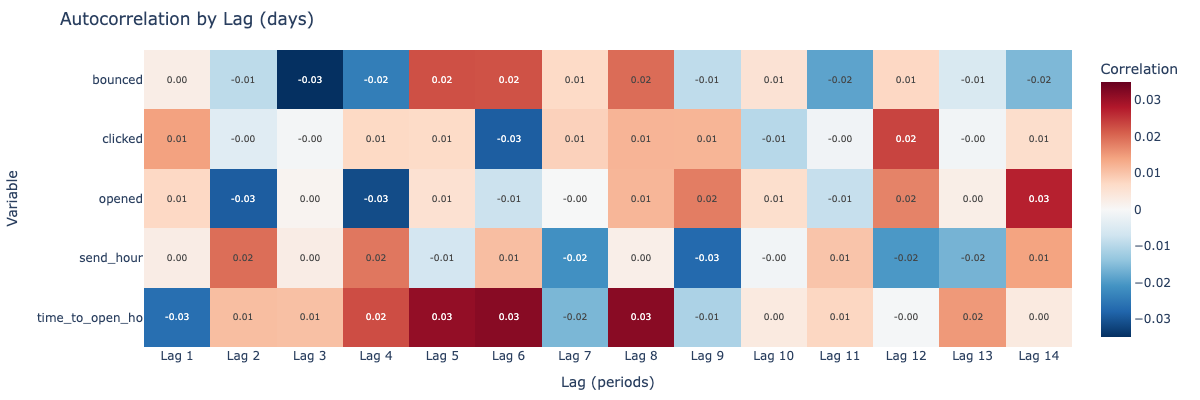


📊 Best Lag per Variable:
   time_to_open_hours: best lag=6d (r=0.03)
   send_hour: best lag=9d (r=-0.03)
   opened: best lag=4d (r=-0.03)
   clicked: best lag=6d (r=-0.03)
   bounced: best lag=3d (r=-0.03)

──────────────────────────────────────────────────────────────────────
📖 INTERPRETATION
──────────────────────────────────────────────────────────────────────

Lag correlation shows how a variable relates to its PAST values:
  • r > 0.5: Strong memory - today predicts tomorrow well
  • r 0.3-0.5: Moderate predictability from past
  • r < 0.3: Weak autocorrelation - lag features less useful

All variables show weak autocorrelation (r < 0.3)
  → Lag features may not be highly predictive
  → Consider aggregated/rolling features instead

──────────────────────────────────────────────────────────────────────
🎯 FEATURE RECOMMENDATIONS
──────────────────────────────────────────────────────────────────────

No lag features recommended (no strong autocorrelation found).


In [25]:
# Lag Correlation Analysis using TemporalFeatureAnalyzer
if ENTITY_COLUMN and sparkline_cols:
    lag_cols = sparkline_cols[:6]
    max_lag = 14
    
    print("="*70)
    print("LAG CORRELATION ANALYSIS")
    print("="*70)
    
    if 'feature_analyzer' not in dir():
        feature_analyzer = TemporalFeatureAnalyzer(time_column=TIME_COLUMN, entity_column=ENTITY_COLUMN)
    
    # Calculate lag correlations using framework
    lag_results = feature_analyzer.calculate_lag_correlations(df, lag_cols, max_lag=max_lag)
    
    # Build data for heatmap
    lag_corr_data = {col: result.correlations for col, result in lag_results.items()}
    
    # Use ChartBuilder for visualization
    fig = charts.lag_correlation_heatmap(
        lag_corr_data,
        max_lag=max_lag,
        title="Autocorrelation by Lag (days)"
    )
    display_figure(fig)
    
    # Display framework results
    print("\n📊 Best Lag per Variable:")
    for col, result in lag_results.items():
        best_lag_info = f"best lag={result.best_lag}d (r={result.best_correlation:.2f})"
        weekly_info = " [Weekly pattern]" if result.has_weekly_pattern else ""
        print(f"   {col[:25]}: {best_lag_info}{weekly_info}")
    
    # INTERPRETATION SECTION
    print("\n" + "─"*70)
    print("📖 INTERPRETATION")
    print("─"*70)
    print("\nLag correlation shows how a variable relates to its PAST values:")
    print("  • r > 0.5: Strong memory - today predicts tomorrow well")
    print("  • r 0.3-0.5: Moderate predictability from past")
    print("  • r < 0.3: Weak autocorrelation - lag features less useful\n")
    
    interpretation_notes = feature_analyzer.generate_lag_interpretation(lag_results)
    for note in interpretation_notes:
        print(note)
    
    # RECOMMENDATIONS SECTION
    print("\n" + "─"*70)
    print("🎯 FEATURE RECOMMENDATIONS")
    print("─"*70)
    
    lag_recs = feature_analyzer.generate_lag_recommendations(lag_results)
    if lag_recs:
        for rec in lag_recs:
            priority_marker = "🔴" if rec.priority == 1 else "🟡"
            print(f"\n{priority_marker} {rec.action.upper()}")
            print(f"   Column: {rec.source_column}")
            print(f"   {rec.description}")
            print(f"   Params: {rec.params}")
    else:
        print("\nNo lag features recommended (no strong autocorrelation found).")

# Store lag recommendations for pattern_summary
LAG_RECOMMENDATIONS = [{"action": r.action, "source_column": r.source_column, 
                         "description": r.description, "priority": r.priority,
                         "features": [f"{r.source_column}_lag_{r.params.get('lag_days', 7)}d"],
                         "params": r.params}
                        for r in lag_recs] if lag_recs else []


## 1c.15 Predictive Power Analysis (IV & KS Statistics)

**📖 Information Value (IV) and KS Statistics:**

These metrics measure how well features predict the target at entity level:

| Metric | What It Measures | Interpretation |
|--------|------------------|----------------|
| **IV** | Predictive strength across bins | <0.02 weak, 0.02-0.1 medium, 0.1-0.3 strong, >0.3 very strong |
| **KS** | Maximum separation between distributions | Higher = better class separation |

**How These Relate to Other Sections:**

| Section | Metric | Relationship to IV/KS |
|---------|--------|----------------------|
| **1c.10** | Cohen's d | Should correlate - both measure cohort separation. d assumes normality, IV handles non-linear. |
| **1c.12** | Velocity effect sizes | High velocity d → feature changes differently by cohort → may show high IV |
| **1c.13** | Momentum effect sizes | High momentum d → behavioral change patterns differ → may show high IV |
| **1c.16** | Cramér's V | For categorical features (IV/KS is for numeric) |

**Validation:** Features with high Cohen's d (1c.10) should generally show high IV here. Disagreements may indicate non-linear relationships (IV captures) or outlier effects (KS captures).


PREDICTIVE POWER ANALYSIS (IV & KS Statistics)
Analyzing 5 features
Entities: 4,998 (Retained: 1,973, Churned: 3,025)


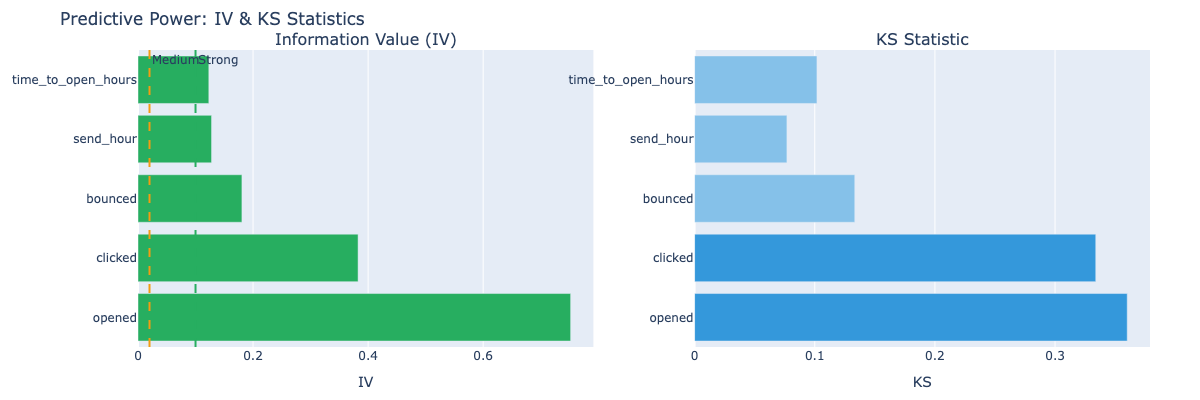


📊 Predictive Power Details:
Feature                         IV IV Strength        KS KS Strength 
----------------------------------------------------------------------
opened                       0.752 suspicious      0.360 medium      
clicked                      0.383 strong          0.334 medium      
bounced                      0.181 medium          0.133 weak        
send_hour                    0.128 medium          0.077 weak        
time_to_open_hours           0.123 medium          0.102 weak        

──────────────────────────────────────────────────────────────────────
📖 INTERPRETATION
──────────────────────────────────────────────────────────────────────

Strong predictors (IV >= 0.1): time_to_open_hours, send_hour, opened, clicked, bounced
  → High predictive value, prioritize in model

📎 Cross-reference with 1c.10 (Cohen's d):
  opened: d=-0.99, IV=0.752 ✓ agree
  clicked: d=-0.63, IV=0.383 ✓ agree
  bounced: d=-0.29, IV=0.181 ~ partial

─────────────────────────────

In [26]:
# Predictive Power Analysis (IV & KS)
if ENTITY_COLUMN and TARGET_COLUMN and sparkline_cols:
    print("="*70)
    print("PREDICTIVE POWER ANALYSIS (IV & KS Statistics)")
    print("="*70)
    
    if 'feature_analyzer' not in dir():
        feature_analyzer = TemporalFeatureAnalyzer(time_column=TIME_COLUMN, entity_column=ENTITY_COLUMN)
    
    analysis_cols = [c for c in sparkline_cols[:8] if c in df.columns]
    
    # Method handles aggregation to entity level internally
    iv_results = feature_analyzer.calculate_predictive_power(df, analysis_cols, TARGET_COLUMN)
    
    n_retained = df.groupby(ENTITY_COLUMN)[TARGET_COLUMN].first().sum()
    n_churned = df[ENTITY_COLUMN].nunique() - n_retained
    print(f"Analyzing {len(analysis_cols)} features")
    print(f"Entities: {df[ENTITY_COLUMN].nunique():,} (Retained: {n_retained:,}, Churned: {n_churned:,})")
    
    # Build visualization data
    iv_data = {col: {"iv": r.information_value, "ks": r.ks_statistic} for col, r in iv_results.items()}
    
    # Create IV/KS comparison chart
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    features = list(iv_data.keys())
    ivs = [iv_data[f]["iv"] for f in features]
    kss = [iv_data[f]["ks"] for f in features]
    
    # Sort by IV
    sorted_idx = sorted(range(len(ivs)), key=lambda i: ivs[i], reverse=True)
    features = [features[i] for i in sorted_idx]
    ivs = [ivs[i] for i in sorted_idx]
    kss = [kss[i] for i in sorted_idx]
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=["Information Value (IV)", "KS Statistic"])
    
    # IV bars with threshold colors
    iv_colors = ["#27ae60" if v >= 0.1 else "#f39c12" if v >= 0.02 else "#95a5a6" for v in ivs]
    fig.add_trace(go.Bar(y=features, x=ivs, orientation="h", marker_color=iv_colors, 
                         showlegend=False, hovertemplate="%{y}: IV=%{x:.3f}<extra></extra>"), row=1, col=1)
    fig.add_vline(x=0.1, line_dash="dash", line_color="#27ae60", annotation_text="Strong", row=1, col=1)
    fig.add_vline(x=0.02, line_dash="dash", line_color="#f39c12", annotation_text="Medium", row=1, col=1)
    
    # KS bars
    ks_colors = ["#3498db" if v >= 0.3 else "#85c1e9" for v in kss]
    fig.add_trace(go.Bar(y=features, x=kss, orientation="h", marker_color=ks_colors,
                         showlegend=False, hovertemplate="%{y}: KS=%{x:.3f}<extra></extra>"), row=1, col=2)
    
    fig.update_layout(height=400, title="Predictive Power: IV & KS Statistics")
    fig.update_xaxes(title_text="IV", row=1, col=1)
    fig.update_xaxes(title_text="KS", row=1, col=2)
    display_figure(fig)
    
    # Details table
    print("\n📊 Predictive Power Details:")
    print(f"{'Feature':<25} {'IV':>8} {'IV Strength':<12} {'KS':>8} {'KS Strength':<12}")
    print("-" * 70)
    for col in features:
        r = iv_results[col]
        print(f"{col[:24]:<25} {r.information_value:>8.3f} {r.iv_interpretation:<12} {r.ks_statistic:>8.3f} {r.ks_interpretation:<12}")
    
    # INTERPRETATION with cross-references
    print("\n" + "─"*70)
    print("📖 INTERPRETATION")
    print("─"*70)
    
    strong_iv = [col for col, r in iv_results.items() if r.information_value >= 0.1]
    medium_iv = [col for col, r in iv_results.items() if 0.02 <= r.information_value < 0.1]
    weak_iv = [col for col, r in iv_results.items() if r.information_value < 0.02]
    
    if strong_iv:
        print(f"\nStrong predictors (IV >= 0.1): {', '.join(strong_iv)}")
        print("  → High predictive value, prioritize in model")
    if medium_iv:
        print(f"\nMedium predictors (IV 0.02-0.1): {', '.join(medium_iv)}")
        print("  → Useful signal, include in model")
    if weak_iv:
        print(f"\nWeak predictors (IV < 0.02): {', '.join(weak_iv)}")
        print("  → Limited predictive value alone")
    
    # Cross-reference with 1c.10 Cohen's d if available
    if 'effect_df' in dir() and len(effect_df) > 0:
        print("\n📎 Cross-reference with 1c.10 (Cohen's d):")
        common_cols = [c for c in features if any(c in ec for ec in effect_df['feature'].tolist())]
        if common_cols:
            for col in common_cols[:3]:
                matching = effect_df[effect_df['feature'].str.contains(col, na=False)]
                if len(matching) > 0:
                    d_val = matching.iloc[0]['cohens_d']
                    iv_val = iv_results.get(col, None)
                    if iv_val:
                        agreement = "✓ agree" if (abs(d_val) >= 0.5 and iv_val.information_value >= 0.1) or \
                                                  (abs(d_val) < 0.2 and iv_val.information_value < 0.02) else "~ partial"
                        print(f"  {col}: d={d_val:+.2f}, IV={iv_val.information_value:.3f} {agreement}")
        else:
            print("  (No overlapping features to compare)")
    
    # RECOMMENDATIONS
    print("\n" + "─"*70)
    print("🎯 FEATURE RECOMMENDATIONS")
    print("─"*70)
    
    if strong_iv:
        print("\n🔴 INCLUDE (Strong IV)")
        for col in strong_iv:
            r = iv_results[col]
            print(f"   • {col}: IV={r.information_value:.3f}, KS={r.ks_statistic:.3f}")
    
    if medium_iv:
        print("\n🟡 INCLUDE (Medium IV)")
        for col in medium_iv[:5]:
            r = iv_results[col]
            print(f"   • {col}: IV={r.information_value:.3f}")
    
    if not strong_iv and not medium_iv:
        print("\nNo features with strong predictive power found.")
        print("   → See 1c.12 (velocity) and 1c.13 (momentum) for derived features")
        print("   → See 1c.16 for categorical feature analysis")
else:
    print("Skipped: Requires entity column, target column, and numeric features")

# Store predictive power recommendations for pattern_summary
PREDICTIVE_POWER_RECOMMENDATIONS = []
if 'iv_results' in dir():
    for col, r in iv_results.items():
        if r.information_value >= 0.1:
            PREDICTIVE_POWER_RECOMMENDATIONS.append({
                "action": "include_feature", "feature": col,
                "iv": r.information_value, "ks": r.ks_statistic, "priority": "high",
                "reason": f"Strong IV={r.information_value:.3f}, KS={r.ks_statistic:.3f}",
                "features": [col]
            })
        elif r.information_value >= 0.02:
            PREDICTIVE_POWER_RECOMMENDATIONS.append({
                "action": "include_feature", "feature": col,
                "iv": r.information_value, "ks": r.ks_statistic, "priority": "medium",
                "reason": f"Medium IV={r.information_value:.3f}",
                "features": [col]
            })


## 1c.16 Categorical Feature Analysis

**📖 What This Measures:**

For each categorical feature, we analyze how its categories relate to the target (retention/churn):

| Metric | What It Measures | How to Read |
|--------|-----------------|-------------|
| **Cramér's V** | Overall association strength (0-1) | Higher = categories strongly predict target |
| **High-Risk Categories** | Categories with target rate < 90% of average | These segments churn more |
| **Low-Risk Categories** | Categories with target rate > 110% of average | These segments retain better |

**Panel Guide:**

| Panel | What It Shows | Color Scheme |
|-------|---------------|--------------|
| **Top-Left** | Feature ranking by Cramér's V | 🔴 Strong ≥0.3 / 🟠 Moderate ≥0.1 / 🔵 Weak |
| **Top-Right** | Count of features per effect bucket | 🟣 Purple gradient (darker = more significant bucket) |
| **Bottom-Left** | High/low risk category counts | 🔴 High-risk (churn) / 🟢 Low-risk (retain) |
| **Bottom-Right** | Category breakdown (top feature) | 🔴 Below avg / 🟢 Above avg / 🔵 Near avg |

**Effect Strength Thresholds:**
| Cramér's V | Strength | Action |
|------------|----------|--------|
| ≥ 0.3 | Strong | Priority feature - include and consider interactions |
| 0.15–0.3 | Moderate | Include in model |
| 0.05–0.15 | Weak | May add noise, test impact |
| < 0.05 | Negligible | Consider dropping |


CATEGORICAL FEATURE ANALYSIS


Features analyzed: 3
Features filtered: 3
Overall target rate: 39.5%


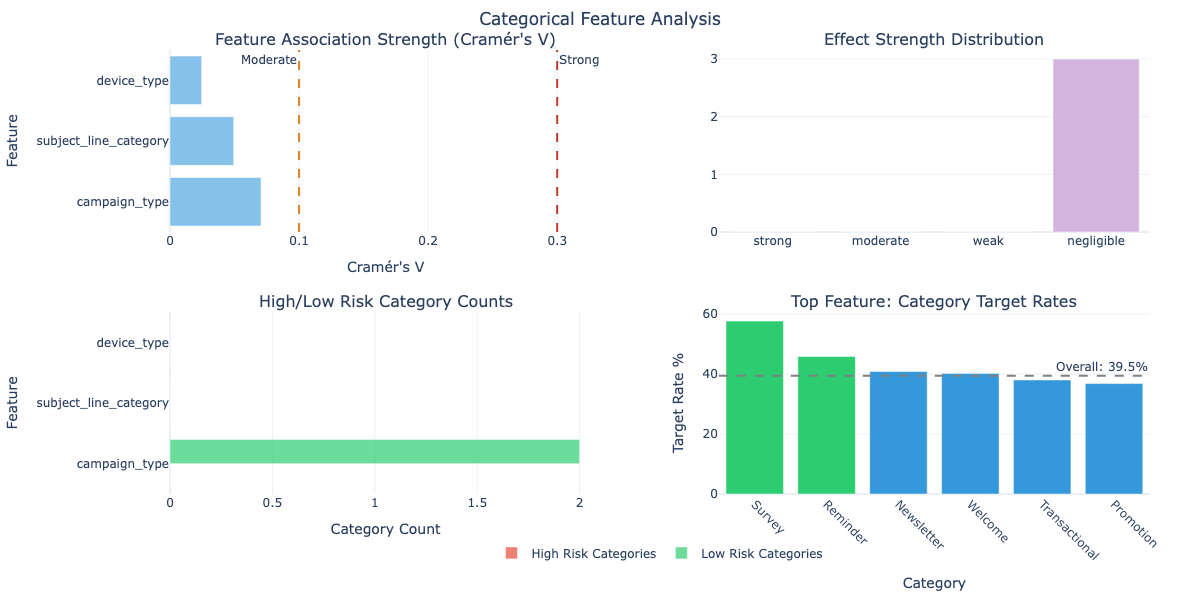


📊 Feature Details:
Feature                Cramér V       Effect   #Cats  High Risk   Low Risk
---------------------------------------------------------------------------
campaign_type             0.070   negligible       6          0          2
subject_line_catego       0.049   negligible       6          0          0
device_type               0.025   negligible       3          0          0

──────────────────────────────────────────────────────────────────────
📖 INTERPRETATION
──────────────────────────────────────────────────────────────────────

Weak/negligible (3): campaign_type, subject_line_category, device_type
  → Limited predictive value, may add noise

──────────────────────────────────────────────────────────────────────
🎯 FEATURE RECOMMENDATIONS
──────────────────────────────────────────────────────────────────────

No strong categorical predictors found.
   • Consider creating derived features (e.g., category combinations)
   • Or focus on numeric/temporal features


In [27]:
# Categorical Feature Analysis
from customer_retention.stages.profiling import analyze_categorical_features

if ENTITY_COLUMN and TARGET_COLUMN:
    print("="*70)
    print("CATEGORICAL FEATURE ANALYSIS")
    print("="*70)
    
    # Aggregate to entity level (take mode for categorical columns)
    cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns 
                if c not in [ENTITY_COLUMN, TIME_COLUMN, TARGET_COLUMN]]
    
    if cat_cols:
        entity_cats_df = df.groupby(ENTITY_COLUMN).agg(
            {c: lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None for c in cat_cols}
        ).reset_index()
        entity_target = df.groupby(ENTITY_COLUMN)[TARGET_COLUMN].first().reset_index()
        entity_data = entity_cats_df.merge(entity_target, on=ENTITY_COLUMN)
        
        cat_result = analyze_categorical_features(entity_data, ENTITY_COLUMN, TARGET_COLUMN)
        
        print(f"Features analyzed: {len(cat_result.feature_insights)}")
        print(f"Features filtered: {len(cat_result.filtered_columns)}")
        print(f"Overall target rate: {cat_result.overall_target_rate:.1%}")
        
        if cat_result.feature_insights:
            # VISUALS
            fig = charts.categorical_analysis_panel(cat_result.feature_insights, cat_result.overall_target_rate)
            display_figure(fig)
            
            # DETAILS TABLE
            print("\n📊 Feature Details:")
            print(f"{'Feature':<20} {'Cramér V':>10} {'Effect':>12} {'#Cats':>7} {'High Risk':>10} {'Low Risk':>10}")
            print("-" * 75)
            for insight in cat_result.feature_insights:
                print(f"{insight.feature_name[:19]:<20} {insight.cramers_v:>10.3f} {insight.effect_strength:>12} "
                      f"{insight.n_categories:>7} {len(insight.high_risk_categories):>10} {len(insight.low_risk_categories):>10}")
            
            # INTERPRETATION
            print("\n" + "─"*70)
            print("📖 INTERPRETATION")
            print("─"*70)
            
            strong = [i for i in cat_result.feature_insights if i.effect_strength == "strong"]
            moderate = [i for i in cat_result.feature_insights if i.effect_strength == "moderate"]
            weak = [i for i in cat_result.feature_insights if i.effect_strength in ("weak", "negligible")]
            
            if strong:
                print(f"\nStrong predictors ({len(strong)}): {', '.join(i.feature_name for i in strong)}")
                print("  → These features have clear category-target relationships")
                print("  → Include in model, consider one-hot encoding")
            
            if moderate:
                print(f"\nModerate predictors ({len(moderate)}): {', '.join(i.feature_name for i in moderate)}")
                print("  → Some predictive power, include if cardinality is reasonable")
            
            if weak:
                print(f"\nWeak/negligible ({len(weak)}): {', '.join(i.feature_name for i in weak)}")
                print("  → Limited predictive value, may add noise")
            
            # High-risk category insights
            all_high_risk = [(i.feature_name, c) for i in cat_result.feature_insights for c in i.high_risk_categories[:2]]
            if all_high_risk:
                print("\nHigh-risk segments (below-average retention):")
                for feat, cat in all_high_risk[:5]:
                    print(f"  • {feat} = '{cat}'")
            
            # RECOMMENDATIONS
            print("\n" + "─"*70)
            print("🎯 FEATURE RECOMMENDATIONS")
            print("─"*70)
            
            if cat_result.recommendations:
                for rec in cat_result.recommendations:
                    priority_marker = "🔴" if rec.get('priority') == 'high' else "🟡"
                    print(f"\n{priority_marker} {rec.get('action', 'RECOMMENDATION').upper()}")
                    print(f"   {rec.get('reason', '')}")
            else:
                # Generate recommendations based on analysis
                if strong:
                    print("\n🔴 INCLUDE STRONG PREDICTORS")
                    for i in strong:
                        print(f"   • {i.feature_name}: V={i.cramers_v:.3f}, {i.n_categories} categories")
                
                if any(i.n_categories > 20 for i in cat_result.feature_insights):
                    high_card = [i for i in cat_result.feature_insights if i.n_categories > 20]
                    print("\n🟡 HIGH CARDINALITY - CONSIDER GROUPING")
                    for i in high_card:
                        print(f"   • {i.feature_name}: {i.n_categories} categories → group rare categories")
                
                if not strong and not moderate:
                    print("\nNo strong categorical predictors found.")
                    print("   • Consider creating derived features (e.g., category combinations)")
                    print("   • Or focus on numeric/temporal features")
        else:
            print("\nNo categorical features passed filtering criteria.")
            if cat_result.filtered_columns:
                print("Filtered out:")
                for col in cat_result.filtered_columns[:5]:
                    reason = cat_result.filter_reasons.get(col, "unknown")
                    print(f"  • {col}: {reason}")
    else:
        print("No categorical columns found in dataset.")
else:
    print("Skipped: Requires both entity and target columns")


## 1c.17 Feature Engineering Summary

**📋 Feature Types with Configured Windows:**

The table below shows feature formulas using windows derived from 01a findings.
Run the next cell to see actual values for your data.


In [28]:
# Feature Engineering Recommendations
print("="*80)
print("FEATURE ENGINEERING RECOMMENDATIONS")
print("="*80)

# Display configured windows from pattern_config
momentum_pairs = pattern_config.get_momentum_pairs()
short_w = momentum_pairs[0][0] if momentum_pairs else 7
long_w = momentum_pairs[0][1] if momentum_pairs else 30

print(f"""
┌─────────────────┬────────────────────────────────────────────────────┐
│ Feature Type    │ Formula (using configured windows)                 │
├─────────────────┼────────────────────────────────────────────────────┤
│ Velocity        │ (value_now - value_{short_w}d_ago) / {short_w}                 │
│ Acceleration    │ velocity_now - velocity_{short_w}d_ago                   │
│ Momentum        │ mean_{short_w}d / mean_{long_w}d                              │
│ Lag             │ df[col].shift(N)                                   │
│ Rolling Mean    │ df[col].rolling({short_w}).mean()                        │
│ Rolling Std     │ df[col].rolling({long_w}).std()                         │
│ Ratio           │ sum_{long_w}d / sum_all_time                            │
└─────────────────┴────────────────────────────────────────────────────┘

Windows derived from 01a findings: {pattern_config.aggregation_windows}
Velocity window: {pattern_config.velocity_window_days}d
Momentum pairs: {momentum_pairs}
""")

# Framework recommendations (without target - event-level data)
if 'feature_analyzer' in dir() and sparkline_cols:
    recommendations = feature_analyzer.get_feature_recommendations(
        df, value_columns=sparkline_cols, target_column=None
    )
    if recommendations:
        print("🎯 Framework Recommendations (based on temporal patterns):")
        for rec in recommendations[:5]:
            print(f"   • {rec.feature_type.value}: {rec.source_column} → {rec.feature_name}")
            print(f"     Formula: {rec.formula}")
            print(f"     Rationale: {rec.rationale}")
        print("""
💡 Note: Target-based recommendations require entity-level data.
   Run notebook 01d first to aggregate, then 02 for target analysis.
""")


FEATURE ENGINEERING RECOMMENDATIONS

┌─────────────────┬────────────────────────────────────────────────────┐
│ Feature Type    │ Formula (using configured windows)                 │
├─────────────────┼────────────────────────────────────────────────────┤
│ Velocity        │ (value_now - value_180d_ago) / 180                 │
│ Acceleration    │ velocity_now - velocity_180d_ago                   │
│ Momentum        │ mean_180d / mean_365d                              │
│ Lag             │ df[col].shift(N)                                   │
│ Rolling Mean    │ df[col].rolling(180).mean()                        │
│ Rolling Std     │ df[col].rolling(365).std()                         │
│ Ratio           │ sum_365d / sum_all_time                            │
└─────────────────┴────────────────────────────────────────────────────┘

Windows derived from 01a findings: ['180d', '365d', 'all_time']
Velocity window: 180d
Momentum pairs: [(180, 365)]



🎯 Framework Recommendations (based on temporal patterns):
   • momentum: clicked → clicked_momentum_7_30
     Formula: mean_7d / mean_30d
     Rationale: Momentum indicates accelerating behavior
   • momentum: bounced → bounced_momentum_7_30
     Formula: mean_7d / mean_30d
     Rationale: Momentum indicates decelerating behavior

💡 Note: Target-based recommendations require entity-level data.
   Run notebook 01d first to aggregate, then 02 for target analysis.



In [29]:
print("\n" + "="*70)
print("TEMPORAL PATTERN SUMMARY")
print("="*70)

# Windows used
print(f"\n⚙️ CONFIGURED WINDOWS: {pattern_config.aggregation_windows}")
print(f"   Velocity: {pattern_config.velocity_window_days}d | Momentum: {pattern_config.get_momentum_pairs()}")

# Trend summary
print(f"\n📈 TREND:")
print(f"   Direction: {trend_result.direction.value}")
print(f"   Confidence: {trend_result.confidence}")

# Seasonality summary
print(f"\n🔁 SEASONALITY:")
if seasonality_results:
    for sr in seasonality_results[:2]:
        period_name = sr.period_name or f"{sr.period}-day"
        print(f"   {period_name.title()} pattern (strength: {sr.strength:.2f})")
else:
    print("   No significant seasonality detected")

# Recency summary
if ENTITY_COLUMN:
    print(f"\n⏱️ RECENCY:")
    print(f"   Median: {recency_result.median_recency_days:.0f} days")
    if recency_result.target_correlation:
        corr = recency_result.target_correlation
        print(f"   Target correlation: {corr:.3f} {'(strong signal)' if abs(corr) > 0.3 else ''}")

# Velocity summary (if computed)
if 'velocity_summary' in dir() and velocity_summary:
    print(f"\n🚀 VELOCITY ({pattern_config.velocity_window_days}d window):")
    divergent = [col for col, v in velocity_summary.items() if v.get('divergent')]
    if divergent:
        print(f"   Divergent columns (retained vs churned): {divergent}")
    else:
        print("   No significant divergence between cohorts")

# Momentum summary (if computed)
if 'momentum_data' in dir() and momentum_data:
    print(f"\n📊 MOMENTUM ({pattern_config.get_momentum_pairs()[0] if pattern_config.get_momentum_pairs() else 'N/A'}):")
    if 'divergent_cols' in dir() and divergent_cols:
        # Filter out target to prevent misleading metadata
        filtered_divergent = [c for c in divergent_cols if c.lower() != TARGET_COLUMN.lower()] if TARGET_COLUMN else divergent_cols
        if filtered_divergent:
            print(f"   High-signal columns: {filtered_divergent}")
        else:
            print("   No significant momentum differences detected (target excluded)")
    else:
        print("   No significant momentum differences detected")



TEMPORAL PATTERN SUMMARY

⚙️ CONFIGURED WINDOWS: ['180d', '365d', 'all_time']
   Velocity: 180d | Momentum: [(180, 365)]

📈 TREND:
   Direction: stable
   Confidence: medium

🔁 SEASONALITY:
   Weekly pattern (strength: 0.48)
   Tri-Weekly pattern (strength: 0.48)

⏱️ RECENCY:
   Median: 246 days
   Target correlation: 0.772 (strong signal)


In [30]:
# Feature engineering recommendations based on patterns
print("\n" + "="*70)
print("RECOMMENDED TEMPORAL FEATURES")
print("="*70)

print("\n\U0001f6e0\ufe0f Based on detected patterns, consider these features:\n")

print("1. RECENCY FEATURES:")
print("   - days_since_last_event")
print("   - log_days_since_last_event (if right-skewed)")
print("   - recency_bucket (categorical: 0-7d, 8-30d, etc.)")

if seasonality_results:
    weekly = any(6 <= sr.period <= 8 for sr in seasonality_results)
    monthly = any(28 <= sr.period <= 32 for sr in seasonality_results)
    
    print("\n2. SEASONALITY FEATURES:")
    if weekly:
        print("   - is_weekend (binary)")
        print("   - day_of_week_sin, day_of_week_cos (cyclical encoding)")
    if monthly:
        print("   - day_of_month")
        print("   - is_month_start, is_month_end")

print("\n3. TREND-ADJUSTED FEATURES:")
if trend_result.direction in [TrendDirection.INCREASING, TrendDirection.DECREASING]:
    print("   - event_count_recent_vs_overall (ratio)")
    print("   - activity_trend_direction (for each entity)")
else:
    print("   - Standard time-window aggregations should work well")

print("\n4. COHORT FEATURES:")
print("   - cohort_month (categorical or ordinal)")
print("   - tenure_days (days since first event)")


RECOMMENDED TEMPORAL FEATURES

🛠️ Based on detected patterns, consider these features:

1. RECENCY FEATURES:
   - days_since_last_event
   - log_days_since_last_event (if right-skewed)
   - recency_bucket (categorical: 0-7d, 8-30d, etc.)

2. SEASONALITY FEATURES:
   - is_weekend (binary)
   - day_of_week_sin, day_of_week_cos (cyclical encoding)

3. TREND-ADJUSTED FEATURES:
   - Standard time-window aggregations should work well

4. COHORT FEATURES:
   - cohort_month (categorical or ordinal)
   - tenure_days (days since first event)


## 1c.18 Save Pattern Analysis Results

In [31]:
# Store pattern analysis results in findings with actionable recommendations
pattern_summary = {
    "windows_used": {
        # Note: aggregation_windows already stored in ts_metadata.suggested_aggregations
        "velocity_window": pattern_config.velocity_window_days,
        "momentum_pairs": pattern_config.get_momentum_pairs(),
    },
    "trend": {
        "direction": trend_result.direction.value,
        "strength": trend_result.strength,
        "confidence": trend_result.confidence,
        "recommendations": TREND_RECOMMENDATIONS if 'TREND_RECOMMENDATIONS' in dir() else [],
    },
    "seasonality": {
        "patterns": [
            {"period": sr.period, "name": sr.period_name, "strength": sr.strength,
             "window_aligned": sr.period in window_lags if 'window_lags' in dir() else False}
            for sr in seasonality_results
        ],
        "recommendations": [],
    },
}

# Generate seasonality recommendations
seasonality_recs = []
if seasonality_results:
    strong_patterns = [sr for sr in seasonality_results if sr.strength > 0.5]
    moderate_patterns = [sr for sr in seasonality_results if 0.3 < sr.strength <= 0.5]
    
    for sr in seasonality_results:
        if sr.period == 7:
            seasonality_recs.append({
                "action": "add_cyclical_feature", "feature": "day_of_week", "encoding": "sin_cos",
                "reason": f"Weekly pattern detected (strength={sr.strength:.2f})"
            })
        elif sr.period in [28, 30, 31]:
            seasonality_recs.append({
                "action": "add_cyclical_feature", "feature": "day_of_month", "encoding": "sin_cos",
                "reason": f"Monthly pattern detected (strength={sr.strength:.2f})"
            })
        elif sr.period in [90, 91, 92]:
            seasonality_recs.append({
                "action": "add_cyclical_feature", "feature": "quarter", "encoding": "sin_cos",
                "reason": f"Quarterly pattern detected (strength={sr.strength:.2f})"
            })
    
    if strong_patterns:
        seasonality_recs.append({
            "action": "consider_deseasonalization", "periods": [sr.period for sr in strong_patterns],
            "reason": "Strong seasonal patterns may dominate signal"
        })
    
    if 'window_lags' in dir() and window_lags:
        aligned = [sr for sr in seasonality_results if sr.period in window_lags]
        if aligned:
            seasonality_recs.append({
                "action": "window_captures_cycle", "windows": [sr.period for sr in aligned],
                "reason": "Aggregation window aligns with seasonal cycle"
            })
        else:
            seasonality_recs.append({
                "action": "window_partial_cycle",
                "detected_periods": [sr.period for sr in seasonality_results], "windows": window_lags,
                "reason": "Aggregation windows don't align with detected cycles"
            })

pattern_summary["seasonality"]["recommendations"] = seasonality_recs

# Add temporal pattern recommendations
if 'TEMPORAL_PATTERN_RECOMMENDATIONS' in dir() and TEMPORAL_PATTERN_RECOMMENDATIONS:
    pattern_summary["temporal_patterns"] = {
        "patterns": [{"name": r["pattern"], "variation": r.get("variation", 0), "priority": r["priority"]} for r in TEMPORAL_PATTERN_RECOMMENDATIONS],
        "recommendations": [{"pattern": r["pattern"], "features": r["features"], "priority": r["priority"], "reason": r["reason"]} for r in TEMPORAL_PATTERN_RECOMMENDATIONS if r.get("features")],
    }

# Add recency analysis with recommendations
if ENTITY_COLUMN:
    recency_data = {
        "median_days": recency_result.median_recency_days,
        "target_correlation": recency_result.target_correlation,
    }
    if recency_comparison:
        recency_data.update({
            "effect_size": recency_comparison.cohens_d,
            "effect_interpretation": recency_comparison.effect_interpretation,
            "distribution_pattern": recency_comparison.distribution_pattern,
            "inflection_bucket": recency_comparison.inflection_bucket,
            "retained_median": recency_comparison.retained_stats.median,
            "churned_median": recency_comparison.churned_stats.median,
            "key_findings": [{"finding": f.finding, "metric": f.metric_name, "value": f.metric_value} for f in recency_comparison.key_findings],
            "recommendations": RECENCY_RECOMMENDATIONS,
        })
    pattern_summary["recency"] = recency_data

# Add velocity results
if 'velocity_summary' in dir() and velocity_summary:
    pattern_summary["velocity"] = {col: {"mean_velocity": v["mean_velocity"], "direction": v["direction"]} for col, v in velocity_summary.items()}

# Add momentum results
if 'momentum_data' in dir() and momentum_data:
    pattern_summary["momentum"] = {col: {"retained": v["retained"], "churned": v["churned"]} for col, v in momentum_data.items()}
    if 'divergent_cols' in dir():
        pattern_summary["momentum"]["_divergent_columns"] = [c for c in divergent_cols if c.lower() != TARGET_COLUMN.lower()] if TARGET_COLUMN else divergent_cols

# Add cohort analysis results
if 'COHORT_RECOMMENDATIONS' in dir() and COHORT_RECOMMENDATIONS:
    pattern_summary["cohort"] = {"recommendations": COHORT_RECOMMENDATIONS}


# Add categorical analysis results
if 'cat_result' in dir() and cat_result.feature_insights:
    pattern_summary["categorical"] = {
        "overall_target_rate": cat_result.overall_target_rate,
        "features_analyzed": len(cat_result.feature_insights),
        "columns_filtered": len(cat_result.filtered_columns),
        "insights": [
            {"feature": i.feature_name, "cramers_v": i.cramers_v, "effect_strength": i.effect_strength,
             "high_risk": i.high_risk_categories[:3], "low_risk": i.low_risk_categories[:3]}
            for i in cat_result.feature_insights[:10]
        ],
        "recommendations": cat_result.recommendations,
        "key_findings": cat_result.key_findings,
    }

# Add velocity analysis results and recommendations
if 'VELOCITY_RECOMMENDATIONS' in dir() and VELOCITY_RECOMMENDATIONS:
    pattern_summary["velocity"]["recommendations"] = VELOCITY_RECOMMENDATIONS

# Add momentum recommendations (separate from momentum data which is already stored)
if 'MOMENTUM_RECOMMENDATIONS' in dir() and MOMENTUM_RECOMMENDATIONS:
    if "momentum" not in pattern_summary:
        pattern_summary["momentum"] = {}
    pattern_summary["momentum"]["recommendations"] = MOMENTUM_RECOMMENDATIONS

# Add lag correlation recommendations
if 'LAG_RECOMMENDATIONS' in dir() and LAG_RECOMMENDATIONS:
    pattern_summary["lag"] = {"recommendations": LAG_RECOMMENDATIONS}

# Add sparkline analysis recommendations (trend, seasonality, scaling)
if 'SPARKLINE_RECOMMENDATIONS' in dir() and SPARKLINE_RECOMMENDATIONS:
    pattern_summary["sparkline"] = {"recommendations": SPARKLINE_RECOMMENDATIONS}

# Add effect size recommendations (feature prioritization)
if 'EFFECT_SIZE_RECOMMENDATIONS' in dir() and EFFECT_SIZE_RECOMMENDATIONS:
    pattern_summary["effect_size"] = {"recommendations": EFFECT_SIZE_RECOMMENDATIONS}

# Add predictive power recommendations (IV/KS based)
if 'PREDICTIVE_POWER_RECOMMENDATIONS' in dir() and PREDICTIVE_POWER_RECOMMENDATIONS:
    pattern_summary["predictive_power"] = {"recommendations": PREDICTIVE_POWER_RECOMMENDATIONS}

# Generate feature flags for 01d aggregation
# These flags tell 01d which optional features to include based on analysis results
pattern_summary["feature_flags"] = {
    "include_recency": (
        recency_comparison.cohens_d > 0.2 
        if 'recency_comparison' in dir() and recency_comparison 
        else True
    ),
    "include_tenure": True,  # Default on; could be derived from tenure analysis if available
    "include_lifecycle_quadrant": ts_meta.temporal_segmentation_recommendation is not None if 'ts_meta' in dir() else False,
    "include_trend_features": bool(pattern_summary.get("trend", {}).get("recommendations")),
    "include_seasonality_features": bool(pattern_summary.get("seasonality", {}).get("recommendations")),
    "include_cohort_features": not any(
        r.get("action") == "skip_cohort_features"
        for r in pattern_summary.get("cohort", {}).get("recommendations", [])
    ),
}

# Save to findings
if not findings.metadata:
    findings.metadata = {}
findings.metadata["temporal_patterns"] = pattern_summary
findings.save(FINDINGS_PATH)

print(f"Pattern analysis saved to: {FINDINGS_PATH}")
print(f"Saved sections: {list(pattern_summary.keys())}")

# Print recency recommendations
if pattern_summary.get("recency", {}).get("recommendations"):
    recency_recs = pattern_summary["recency"]["recommendations"]
    print(f"\n⏱️ RECENCY FEATURES TO ADD ({len(recency_recs)}):")
    for rec in recency_recs:
        priority_icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(rec.get("priority", "medium"), "⚪")
        features = rec.get("features", [])
        if features:
            print(f"   {priority_icon} [{rec['priority'].upper()}] {', '.join(features)}")
            print(f"      {rec['reason']}")

# Print cohort recommendations
if "cohort" in pattern_summary:
    cohort_recs = pattern_summary["cohort"].get("recommendations", [])
    feature_recs = [r for r in cohort_recs if r.get("features")]
    skip_recs = [r for r in cohort_recs if r.get("action") == "skip_cohort_features"]
    if skip_recs:
        print(f"\n👥 COHORT: Skip cohort features ({skip_recs[0]['reason']})")
    elif feature_recs:
        print(f"\n👥 COHORT FEATURES TO ADD:")
        for rec in feature_recs:
            print(f"   • {', '.join(rec['features'])} ({rec['priority']} priority)")

# Print trend recommendations
if pattern_summary.get("trend", {}).get("recommendations"):
    trend_recs = [r for r in pattern_summary["trend"]["recommendations"] if r.get("features")]
    if trend_recs:
        print(f"\n📈 TREND FEATURES TO ADD ({len(trend_recs)}):")
        for rec in trend_recs:
            print(f"   • {', '.join(rec['features'])} ({rec['priority']} priority)")

# Print temporal pattern recommendations
if "temporal_patterns" in pattern_summary:
    tp_recs = pattern_summary["temporal_patterns"].get("recommendations", [])
    if tp_recs:
        print(f"\n📅 TEMPORAL PATTERN FEATURES TO ADD ({len(tp_recs)}):")
        for rec in tp_recs:
            print(f"   • {rec['pattern']}: {', '.join(rec['features'])} ({rec['priority']} priority)")


# Print categorical recommendations
if pattern_summary.get("categorical", {}).get("recommendations"):
    cat_recs = pattern_summary["categorical"]["recommendations"]
    print(f"\n🏷️ CATEGORICAL FEATURE RECOMMENDATIONS ({len(cat_recs)}):")
    for rec in cat_recs:
        priority_icon = {"high": "🔴", "medium": "🟡", "low": "🟢"}.get(rec.get("priority", "medium"), "⚪")
        features = rec.get("features", [])
        if features:
            print(f"   {priority_icon} [{rec['priority'].upper()}] {rec['action']}")
            print(f"      {rec['reason']}")
# Print seasonality recommendations
if seasonality_recs:
    print(f"\n🔁 SEASONALITY RECOMMENDATIONS ({len(seasonality_recs)}):")
    for rec in seasonality_recs:
        action = rec["action"].replace("_", " ").title()
        print(f"   • {action}: {rec['reason']}")

Pattern analysis saved to: /Users/Vital/python/CustomerRetention/experiments/findings/customer_emails_408768_findings.yaml
Saved sections: ['windows_used', 'trend', 'seasonality', 'temporal_patterns', 'recency', 'cohort', 'categorical', 'momentum', 'sparkline', 'effect_size', 'predictive_power', 'feature_flags']

⏱️ RECENCY FEATURES TO ADD (1):
   🔴 [HIGH] days_since_last_event, log_recency
      Target=1 is minority (39%) - interpret as CHURN; recency pattern is classic churn behavior

👥 COHORT: Skip cohort features (90% onboarded in 2015 - insufficient variation)

📅 TEMPORAL PATTERN FEATURES TO ADD (4):
   • year: year_categorical (high priority)
   • 7d_cycle: lag_7d_ratio (medium priority)
   • 21d_cycle: lag_21d_ratio (medium priority)
   • 14d_cycle: lag_14d_ratio (medium priority)

🔁 SEASONALITY RECOMMENDATIONS (2):
   • Add Cyclical Feature: Weekly pattern detected (strength=0.48)
   • Window Partial Cycle: Aggregation windows don't align with detected cycles


---

## Summary: What We Learned

In this notebook, we analyzed temporal patterns:

1. **Trend Detection** - Identified long-term direction in data
2. **Seasonality** - Found periodic patterns (weekly, monthly)
3. **Cohort Analysis** - Compared behavior by entity join date
4. **Recency Analysis** - Measured how recent activity relates to outcomes
5. **Feature Recommendations** - Generated feature engineering suggestions

## Pattern Summary

| Pattern | Status | Recommendation |
|---------|--------|----------------|
| Trend | Check findings | Detrend if strong |
| Seasonality | Check findings | Add cyclical features |
| Cohort Effects | Check findings | Add cohort indicators |
| Recency Effects | Check findings | Prioritize recent windows |

---

## Next Steps

**Complete the Event Bronze Track:**
- **01d_event_aggregation.ipynb** - Aggregate events to entity-level (produces new dataset)

After 01d produces the aggregated dataset, continue with:
- **02_column_deep_dive.ipynb** - Profile aggregated feature distributions
- **03_quality_assessment.ipynb** - Quality checks on aggregated data
- **04_relationship_analysis.ipynb** - Feature correlations and relationships

The aggregated data from 01d becomes the input for the Entity Bronze Track.